# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [249]:
# Importing the required library.
import pandas as pd
import numpy as np

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import math
import operator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from catboost import CatBoostRegressor

In [250]:
#Update default params to plot
plt.rcParams.update(plt.rcParamsDefault)
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plot_colours = 'rbkbymc'

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [251]:
#Read the given data files into data frames and filter out fraudulent and non-fraudulent dataframe

#Input file path. submission.csv will also use the same path.
file_path = 'C:/Users/ajayg/jupyter-notebooks/data/ieee-fraud-detection/'

train_trans = pd.read_csv(file_path+'train_transaction.csv' , low_memory=False)
train_iden = pd.read_csv(file_path+'train_identity.csv')
test_trans = pd.read_csv(file_path+'test_transaction.csv')
test_iden = pd.read_csv(file_path+'test_identity.csv')

#Filter out the data to examine just the fraudulent transactions.
is_Fraud = train_trans['isFraud'] == 1
tt_isFraud = train_trans[is_Fraud]
tt_isFraud_size = tt_isFraud.shape
print("size of fraud data = " + str(tt_isFraud_size))

is_NFraud = train_trans['isFraud'] == 0
tt_isNFraud = train_trans[is_NFraud]
tt_isNFraud_size = tt_isNFraud.shape
print("size of non-fraud data = " + str(tt_isNFraud_size))

size of fraud data = (20663, 394)
size of non-fraud data = (569877, 394)


In [252]:
#Merge the transaction data and identity data using inner join and left join

#Used for plotting deviceInfo and deviceType
merge_inner = pd.merge(train_trans,train_iden, how='inner',on='TransactionID')
#From Merge inner extract fraud and not fraud data
mergedI_Fraud = merge_inner['isFraud'] == 1
merI_isFraud = merge_inner[mergedI_Fraud]

mergedI_NFraud = merge_inner['isFraud'] == 0
merI_isNFraud = merge_inner[mergedI_NFraud]

#Left join data for modelling
mergeL_train = pd.merge(train_trans,train_iden, how='left',left_on='TransactionID',right_on='TransactionID')
mergeL_test = pd.merge(test_trans,test_iden, how='left',left_on='TransactionID',right_on='TransactionID')

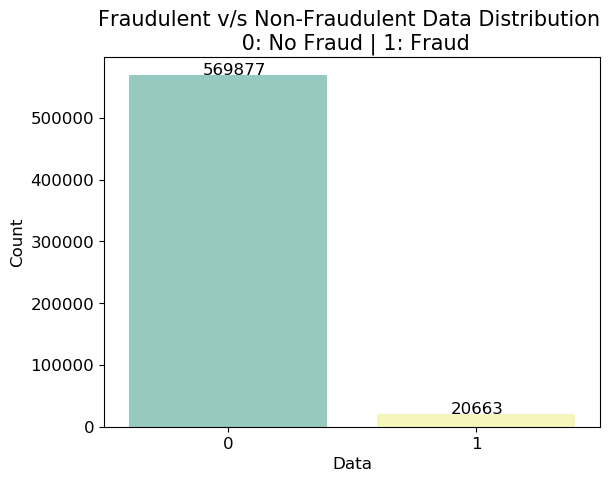

In [253]:
plot_data = sns.countplot(x='isFraud', data=train_trans , palette="Set3")
plot_data.set_title("Fraudulent v/s Non-Fraudulent Data Distribution \n 0: No Fraud | 1: Fraud", fontsize=15)
plot_data.set_xlabel('Data', fontsize=12)
plot_data.set_ylabel('Count', fontsize=12)
for i in plot_data.patches:
    plot_data.annotate('{}'.format(i.get_height()), (i.get_x()+0.3, i.get_height()))
plt.show()

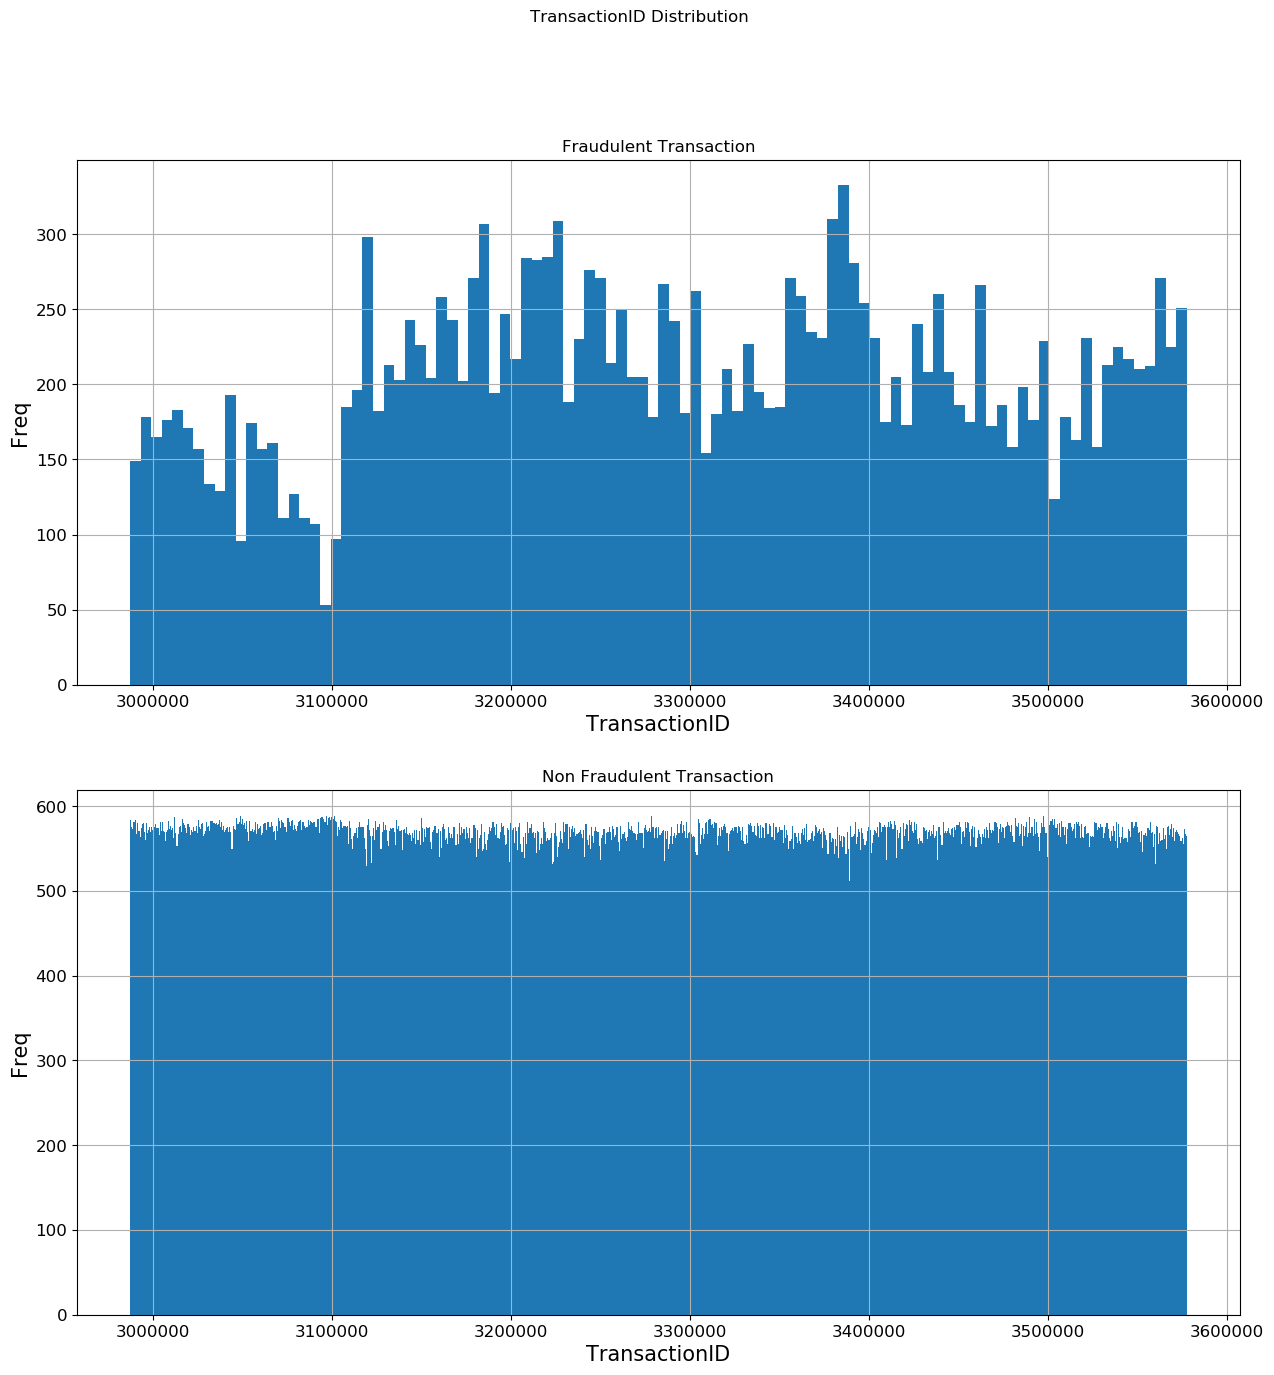

Transaction ID is unique for all data, no inference can be draw from this


In [254]:
#Plot for transaction ID
#2 subplots
#https://matplotlib.org/3.1.1/api/axes_api.html

fig, (ax1, ax2) = plt.subplots(2,figsize=(15,15))
fig.suptitle('TransactionID Distribution',fontsize=12)
ax1.set_title('Fraudulent Transaction')
ax1.set_xlabel('TransactionID')
ax1.set_ylabel('Freq')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_xlabel('TransactionID')
ax2.set_ylabel('Freq')
#Plot transactionID for fraudulent data
_ = tt_isFraud.TransactionID.hist(bins=100, ax=ax1)
#Plot transactionID for fraudulent data
_ = tt_isNFraud.TransactionID.hist(bins = 1000 ,ax=ax2)
plt.show()

print('Transaction ID is unique for all data, no inference can be draw from this')

Fraud Device Types: ['desktop' 'mobile' 'nan']
Fraud Device Count: [5554 5657  107]
Non-Fraud Device Types: ['desktop' 'mobile' 'nan']
Non-Fraud Device Count: [79611 49988  3316]


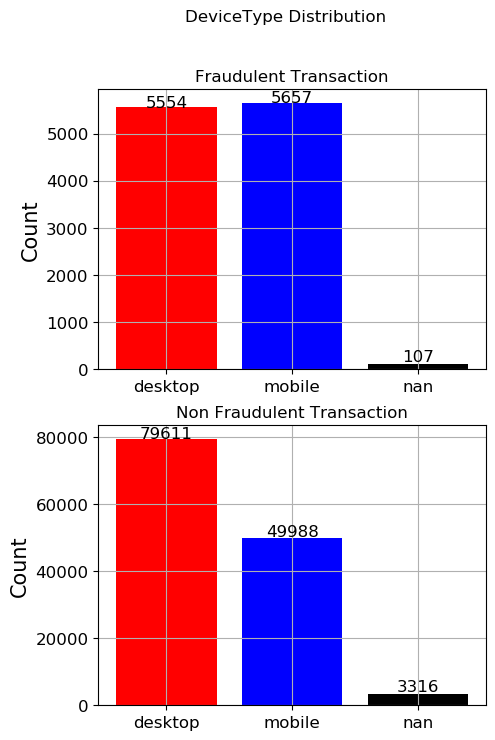

From the above plots we can observe that 
        1. More fraudlent transactions are from Mobile device type 
        2. More Non-Fraudlent transactions is from desktop device type


In [255]:
#Device Type
#Get unique values of device type from the merged data
typ_Fraud , cnt_Fraud = np.unique(merI_isFraud['DeviceType'].tolist() , return_counts=True)
typ_NFraud , cnt_NFraud = np.unique(merI_isNFraud['DeviceType'].tolist() , return_counts=True)
print("Fraud Device Types: " + str(typ_Fraud))
print("Fraud Device Count: " + str(cnt_Fraud))
print("Non-Fraud Device Types: " + str(typ_NFraud))
print("Non-Fraud Device Count: " + str(cnt_NFraud))

#Plot deviceType for fraudulent and non-fradulent data
fig, (ax1, ax2) = plt.subplots(2,figsize=(5,8))
fig.suptitle('DeviceType Distribution',fontsize=12)
ax1.set_title('Fraudulent Transaction')
ax1.set_ylabel('Count')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_ylabel('Count')
ax1.grid()
ax2.grid()
#Plot DeviceType for fraudulent data
rects1 = ax1.bar(typ_Fraud ,cnt_Fraud , color=plot_colours)
#Plot DeviceType for Non-fraudulent data
rects2 = ax2.bar(typ_NFraud ,cnt_NFraud, color=plot_colours )
def autolabel(rects , ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.99*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1 , ax1)
autolabel(rects2,ax2)

plt.show()
print('From the above plots we can observe that \n \
       1. More fraudlent transactions are from Mobile device type \n \
       2. More Non-Fraudlent transactions is from desktop device type')

Fraud Device Info with count > 30 is : (30, 2)
Non-Fraud Device Info with count > 30 is : (180, 2)


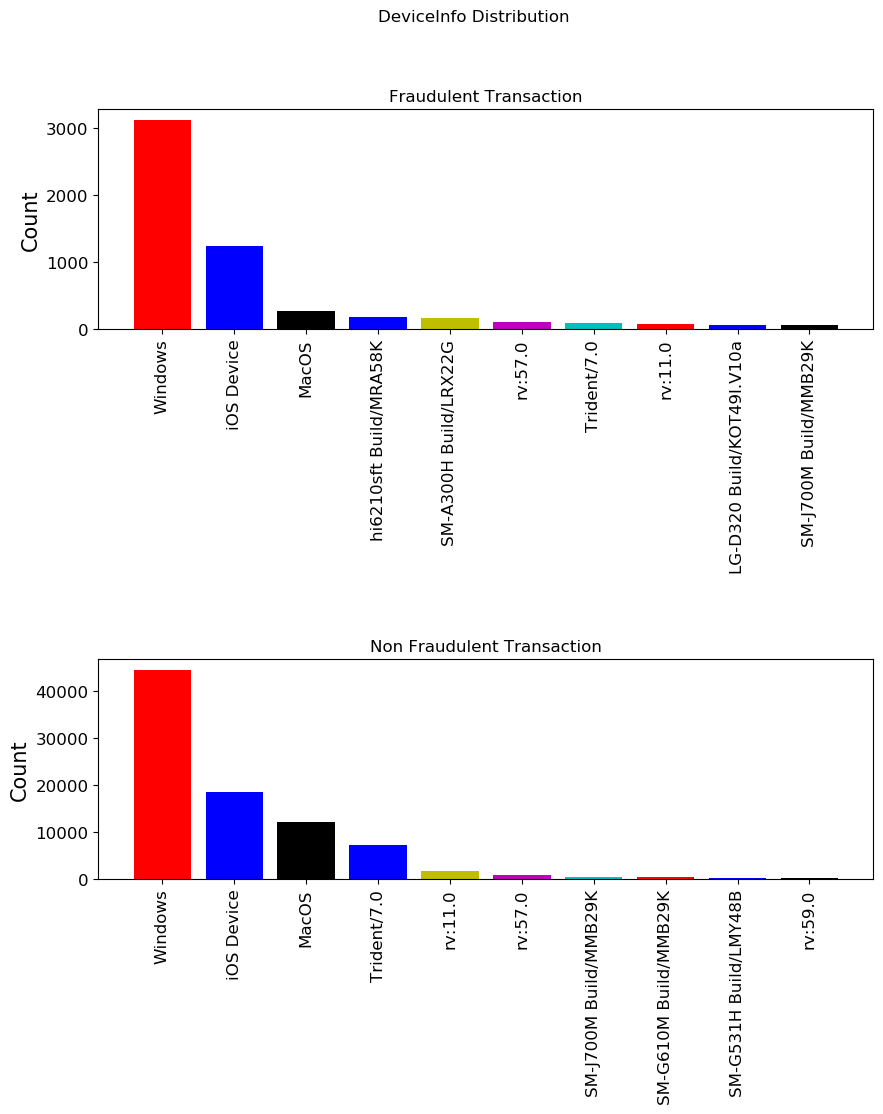

From the above plots we can observe that Both fraudulent and 
 non-fraudulent transactions are from DeviceInfo = 'Windows'


In [256]:
#DeviceInfo
#This will get frequency of a particular column and the count to it.
merI_isFraud_DI_value = merI_isFraud['DeviceInfo'].value_counts()
merI_isFraud_DevInfo_Count = merI_isFraud_DI_value.rename_axis('DeviceInfo').reset_index(name = 'count')

merI_isNFraud_DI_value = merI_isNFraud['DeviceInfo'].value_counts()
merI_isNFraud_DevInfo_Count = merI_isNFraud_DI_value.rename_axis('DeviceInfo').reset_index(name = 'count')

#As there are lot of values for device info consider only those devices info with count >= 30
#And plot first 10 data as done below
merI_isFraud_DevInfo_Count30 = merI_isFraud_DevInfo_Count[merI_isFraud_DevInfo_Count['count'] >= 30]
merI_isNFraud_DevInfo_Count30 = merI_isNFraud_DevInfo_Count[merI_isNFraud_DevInfo_Count['count'] >= 30]
print("Fraud Device Info with count > 30 is : "+str(merI_isFraud_DevInfo_Count30.shape))
print("Non-Fraud Device Info with count > 30 is : "+str(merI_isNFraud_DevInfo_Count30.shape))


#Now take only the first 10 datas
merI_isFraud_DevInfo_Count10 = merI_isFraud_DevInfo_Count30.head(10)
merI_isNFraud_DevInfo_Count10 = merI_isNFraud_DevInfo_Count30.head(10)

fig, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
fig.suptitle('DeviceInfo Distribution',fontsize=12)
fig.subplots_adjust(hspace=1.5)
ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)
ax1.set_title('Fraudulent Transaction')
ax1.set_ylabel('Count')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_ylabel('Count')
#Plot DeviceInfo for fraudulent data
rects1 = ax1.bar(merI_isFraud_DevInfo_Count10['DeviceInfo'] ,merI_isFraud_DevInfo_Count10['count'] , color=plot_colours)
#Plot DeviceInfo for Non-fraudulent data
rects2 = ax2.bar(merI_isNFraud_DevInfo_Count10['DeviceInfo'] ,merI_isNFraud_DevInfo_Count10['count'] , color=plot_colours )
plt.show()
print('From the above plots we can observe that Both fraudulent and \n \
non-fraudulent transactions are from DeviceInfo = \'Windows\'')

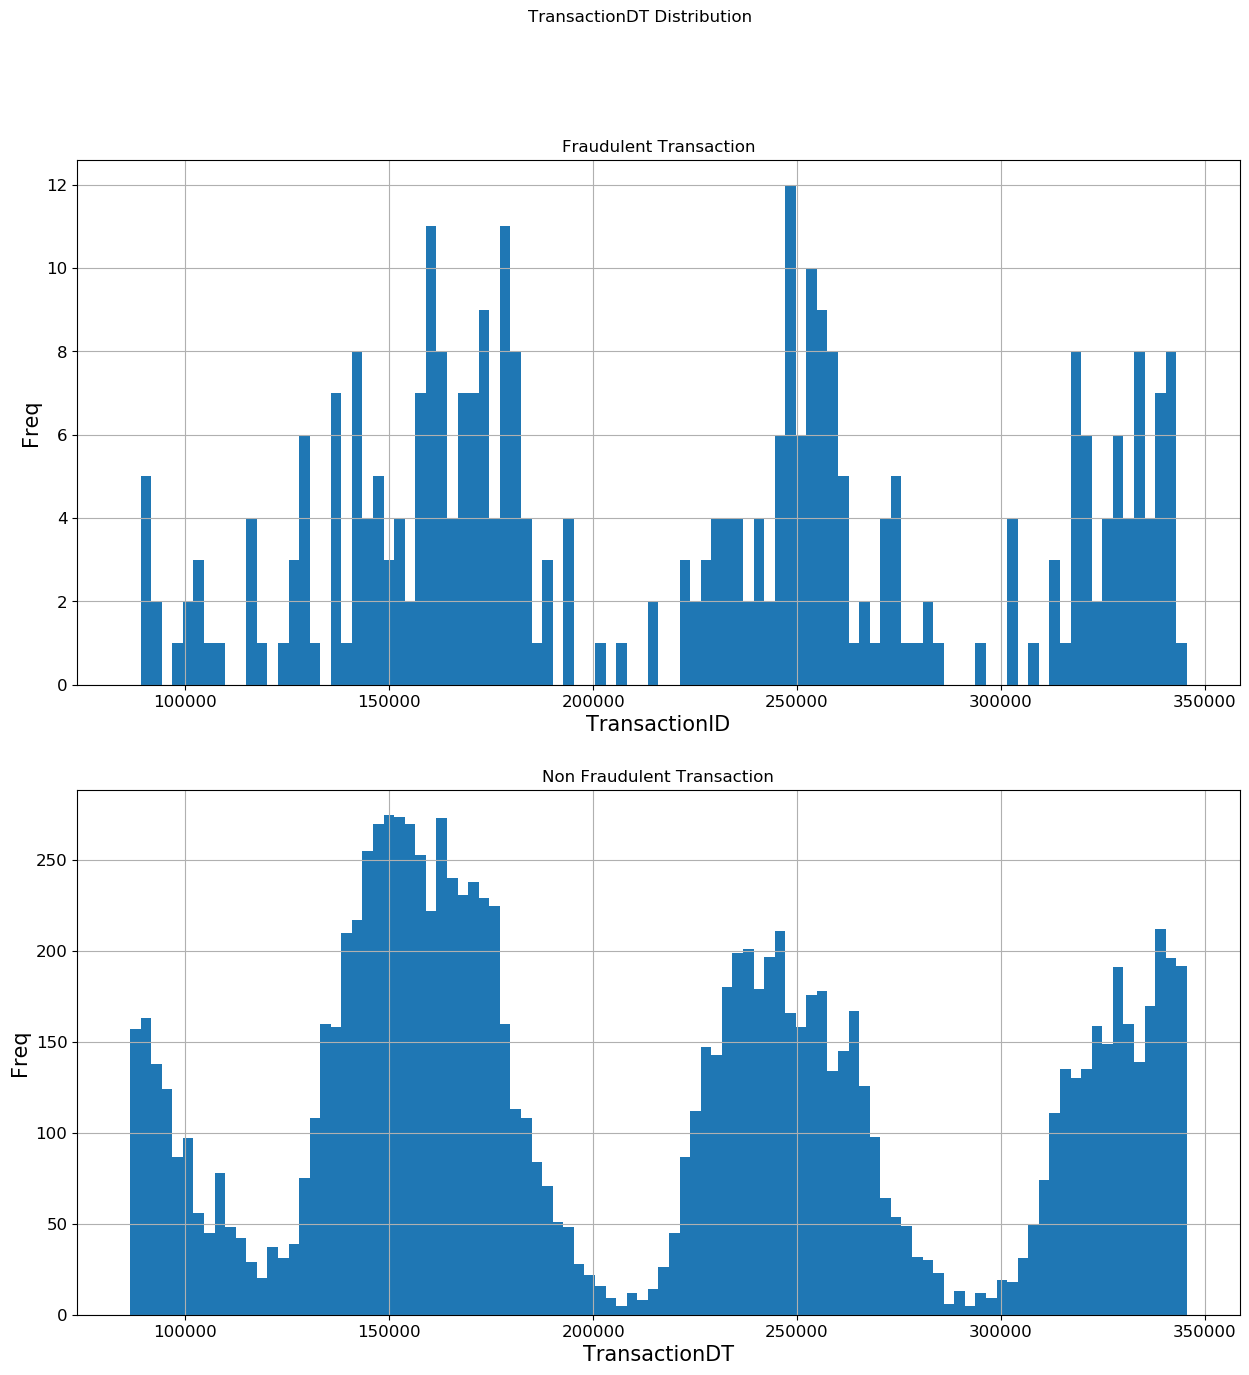

As seen from the above plots 
 A pattern can be seen from the plot where for some range of TransactionDT the number of transactions increases and then decreases which follows a wave pattern 
 So we can plot 2-3 cycles of the data instead of plotting for the entire dataset


In [257]:
#TransactionDT
#TransactionDT is a refernece time. The time can be divided by 3600 to get time in hours. 
#This has be done as part of question 2.

fig, (ax1, ax2) = plt.subplots(2,figsize=(15,15))
fig.suptitle('TransactionDT Distribution',fontsize=12)
ax1.set_title('Fraudulent Transaction')
ax1.set_xlabel('TransactionID')
ax1.set_ylabel('Freq')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_xlabel('TransactionDT')
ax2.set_ylabel('Freq')
#Plot TransationDT for fraudulent data
_ = tt_isFraud.TransactionDT.hist(bins=100, ax=ax1 , range = (86400,345600))
#Plot TransationDT for Non-fraudulent data
_ = tt_isNFraud.TransactionDT.hist(bins=100 ,ax=ax2 , range = (86400,345600))
plt.show()

print('As seen from the above plots \n \
A pattern can be seen from the plot where \
for some range of TransactionDT the number \
of transactions increases and then decreases which follows a wave pattern \n \
So we can plot 2-3 cycles of the data instead of plotting for the entire dataset')

isFraudMaxAmt = 5191.0
isFraudMaxAmt = 0.292
isFraudMeanTAmt = 149.2447785897534

isNFraudMaxTAmt = 31937.391
isNFraudMinAmt = 0.251
isNFraudMeanTAmt = 134.51166457896034


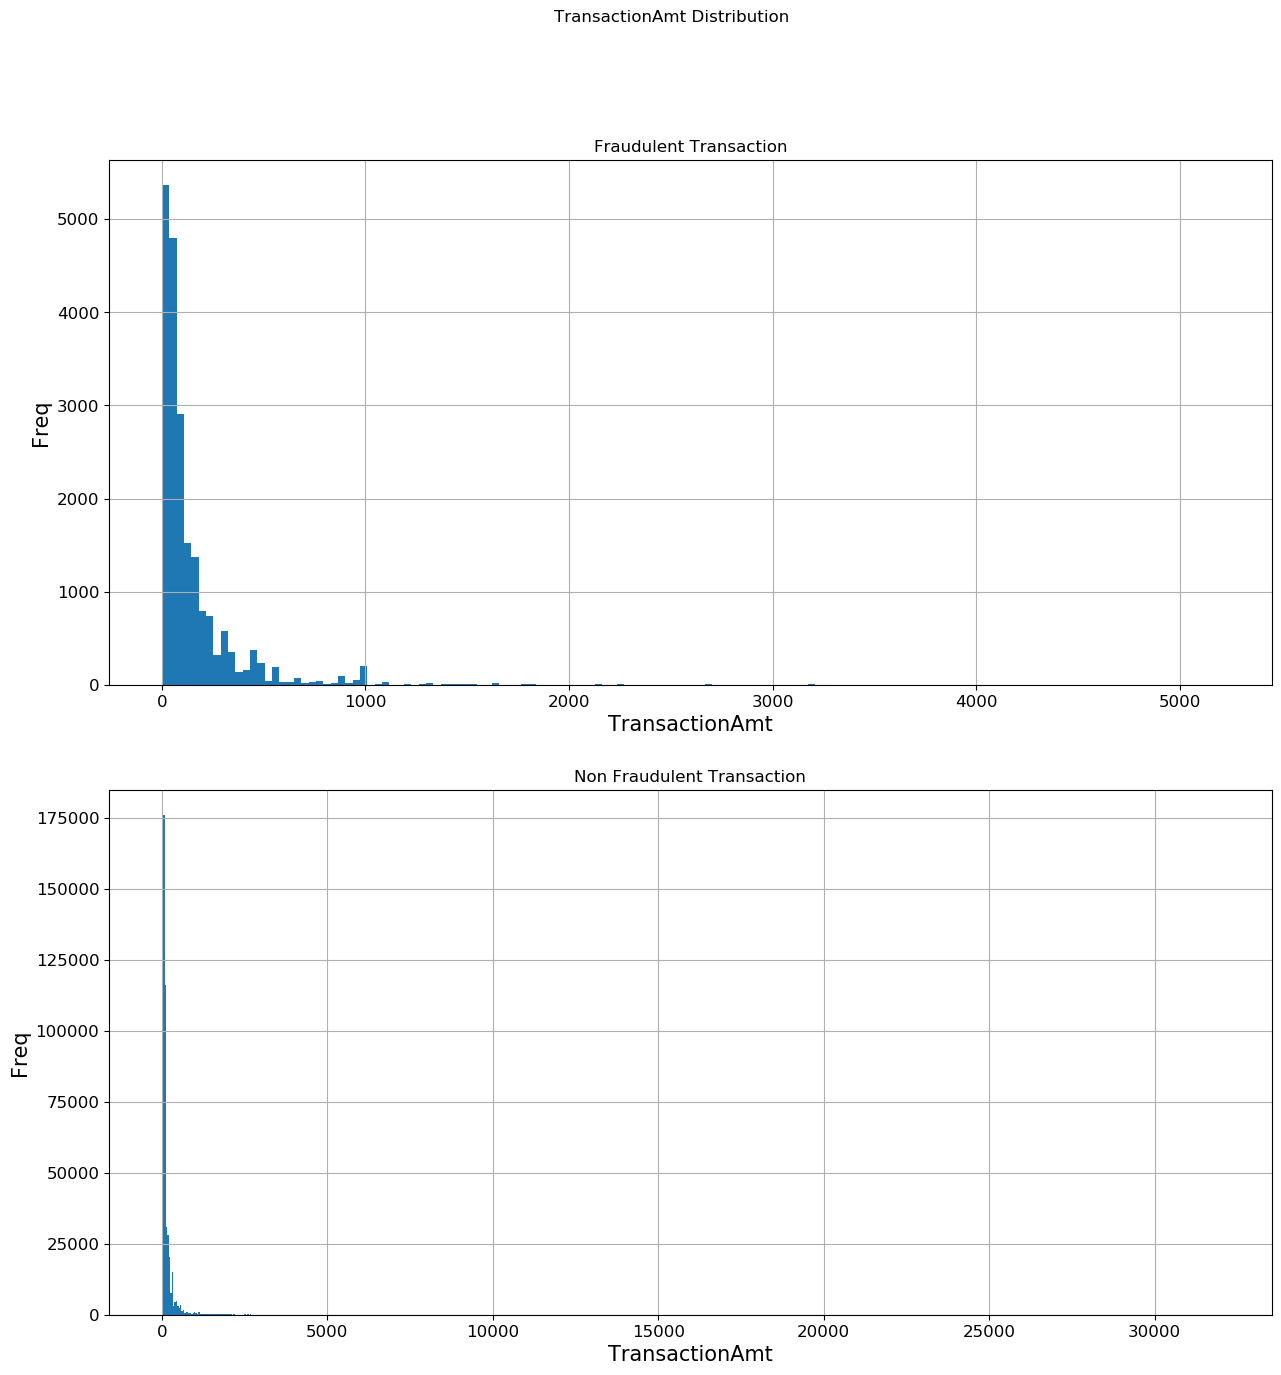

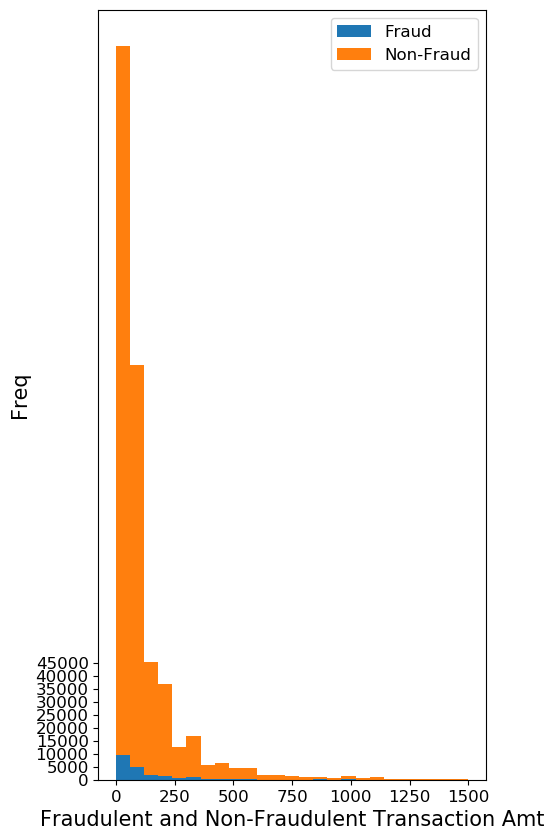

Freq of Fraud Transaction amount is highest in 0-150 
 Freq of Non-Fraud Transaction amount is highest in 0-150 
 isFraudMaxAmt = 5191.0 
 isFraudMaxAmt = 0.292 
 isFraudMeanTAmt = 149.2447785897534 
 isNFraudMaxTAmt = 31937.391 
 isNFraudMinAmt = 0.251 
 isNFraudMeanTAmt = 134.51166457896034


In [258]:
#TransactionAmt.
#calculate min, max and mean of fraud and non-fraud trans.
isFraudMaxTAmt = tt_isFraud['TransactionAmt'].max()
isFraudMinTAmt = tt_isFraud['TransactionAmt'].min()
isFraudMeanTAmt = tt_isFraud['TransactionAmt'].mean()
print("isFraudMaxAmt = " + str(isFraudMaxTAmt))
print("isFraudMaxAmt = " + str(isFraudMinTAmt))
print("isFraudMeanTAmt = " + str(isFraudMeanTAmt))
print()
isNFraudMaxTAmt = tt_isNFraud['TransactionAmt'].max()
isNFraudMinTAmt = tt_isNFraud['TransactionAmt'].min()
isNFraudMeanTAmt = tt_isNFraud['TransactionAmt'].mean()
print("isNFraudMaxTAmt = " + str(isNFraudMaxTAmt))
print("isNFraudMinAmt = " + str(isNFraudMinTAmt))
print("isNFraudMeanTAmt = " + str(isNFraudMeanTAmt))

#Multiple plots below this are shown to compare the fd bins and stacked plot.
fig, (ax1, ax2) = plt.subplots(2,figsize=(15,15))
fig.suptitle('TransactionAmt Distribution',fontsize=12)
ax1.set_title('Fraudulent Transaction')
ax1.set_xlabel('TransactionAmt')
ax1.set_ylabel('Freq')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_xlabel('TransactionAmt')
ax2.set_ylabel('Freq')

sbin = math.ceil(math.sqrt(int(tt_isFraud_size[0])))
sbin1 = math.ceil(math.sqrt(int(tt_isNFraud_size[0])))

_ = tt_isFraud.TransactionAmt.hist(bins = sbin , ax=ax1)
_ = tt_isNFraud.TransactionAmt.hist(bins = sbin1 , ax=ax2)

#Stacked plot
fig, ax = plt.subplots(1,figsize=(5,10))
plt.yticks(range(0,50000,5000))
plt.xlabel('Fraudulent and Non-Fraudulent Transaction Amt')
plt.ylabel('Freq')
_ = plt.hist([tt_isFraud.TransactionAmt,tt_isNFraud.TransactionAmt],stacked=True , bins=25, range=(0,1500))
plt.legend(('Fraud' , 'Non-Fraud'))
plt.show()

print('Freq of Fraud Transaction amount is highest in 0-150 \n \
Freq of Non-Fraud Transaction amount is highest in 0-150 \n \
isFraudMaxAmt = 5191.0 \n \
isFraudMaxAmt = 0.292 \n \
isFraudMeanTAmt = 149.2447785897534 \n \
isNFraudMaxTAmt = 31937.391 \n \
isNFraudMinAmt = 0.251 \n \
isNFraudMeanTAmt = 134.51166457896034')

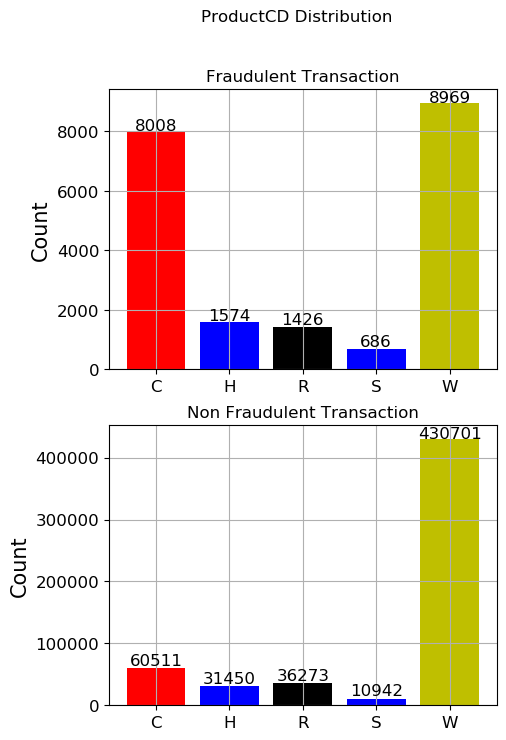

From the above plot we can see that 
 1. For fraudulent transactions product 'W' and product 'C' are more frequent products 
 2. For non-fraud transactions product 'W' has the maximum frequency


In [259]:
#ProductCD
prod_Fraud , prod_cnt_Fraud = np.unique(tt_isFraud['ProductCD'].tolist() , return_counts=True)
prod_NFraud , prod_cnt_NFraud = np.unique(tt_isNFraud['ProductCD'].tolist() , return_counts=True)
fig, (ax1, ax2) = plt.subplots(2,figsize=(5,8))
fig.suptitle('ProductCD Distribution',fontsize=12)
ax1.set_title('Fraudulent Transaction')
ax1.set_ylabel('Count')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_ylabel('Count')
ax1.grid()
ax2.grid()
rects1 = ax1.bar(prod_Fraud ,prod_cnt_Fraud , color=plot_colours)
rects2 = ax2.bar(prod_NFraud ,prod_cnt_NFraud, color=plot_colours )
def autolabel(rects , ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.99*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1 , ax1)
autolabel(rects2,ax2)

plt.show()

print('From the above plot we can see that \n \
1. For fraudulent transactions product \'W\' and product \'C\' are more frequent products \n \
2. For non-fraud transactions product \'W\' has the maximum frequency')

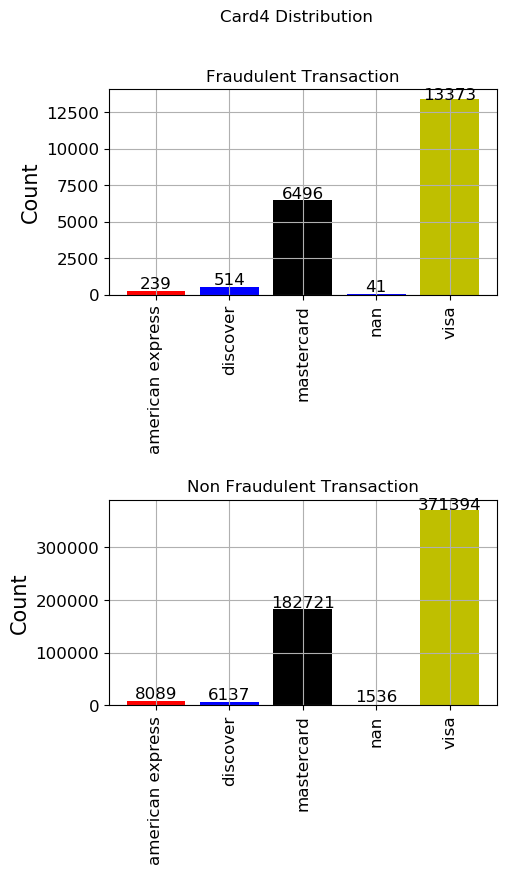

From the above plots we can infer that Both for fraudulent and non-fraudulent transactions the card which is used more is 'VISA'


In [260]:
#Card4
card_Fraud , card_cnt_Fraud = np.unique(tt_isFraud['card4'].tolist() , return_counts=True)
card_NFraud , card_cnt_NFraud = np.unique(tt_isNFraud['card4'].tolist() , return_counts=True)

fig, (ax1, ax2) = plt.subplots(2,figsize=(5,8))
fig.suptitle('Card4 Distribution',fontsize=12)
fig.subplots_adjust(hspace=1)
ax1.set_title('Fraudulent Transaction')
ax1.set_ylabel('Count')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_ylabel('Count')
ax1.grid()
ax2.grid()
ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)
rects1 = ax1.bar(card_Fraud ,card_cnt_Fraud , color=plot_colours)
rects2 = ax2.bar(card_NFraud ,card_cnt_NFraud, color=plot_colours )
def autolabel(rects , ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.985*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1 , ax1)
autolabel(rects2,ax2)

plt.show()

print('From the above plots we can infer that Both for \
fraudulent and non-fraudulent transactions the card which is used more is \'VISA\'')


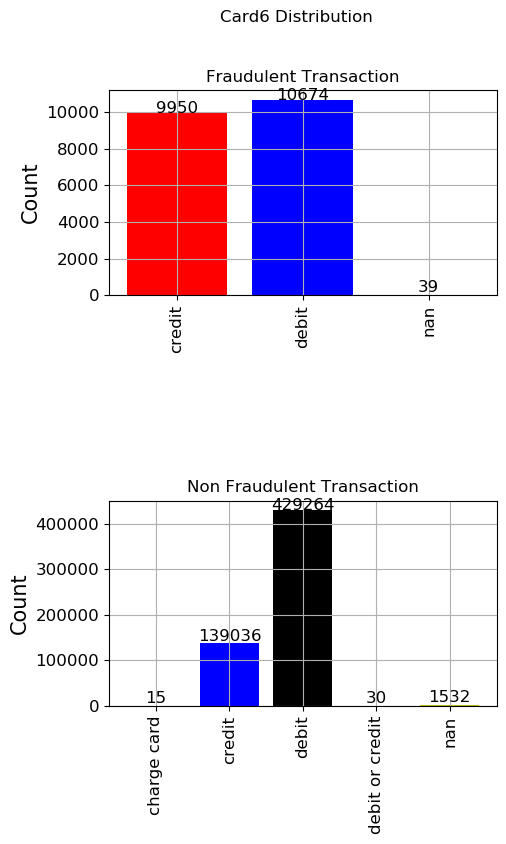

From the above plots we can infer that Both for fraudulent and non-fraudulent transactions the card6 which is used more is 'Debit' 


In [261]:
#Card6
card6_Fraud , card6_cnt_Fraud = np.unique(tt_isFraud['card6'].tolist() , return_counts=True)
card6_NFraud , card6_cnt_NFraud = np.unique(tt_isNFraud['card6'].tolist() , return_counts=True)

fig, (ax1, ax2) = plt.subplots(2,figsize=(5,8))
fig.suptitle('Card6 Distribution',fontsize=12)
fig.subplots_adjust(hspace=1)
ax1.set_title('Fraudulent Transaction')
ax1.set_ylabel('Count')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_ylabel('Count')
ax1.grid()
ax2.grid()
ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)
rects1 = ax1.bar(card6_Fraud ,card6_cnt_Fraud , color=plot_colours)
rects2 = ax2.bar(card6_NFraud ,card6_cnt_NFraud, color=plot_colours )
def autolabel(rects , ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.985*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1 , ax1)
autolabel(rects2,ax2)

plt.show()

print('From the above plots we can infer that Both for \
fraudulent and non-fraudulent transactions the card6 which is used more is \'Debit\' ')

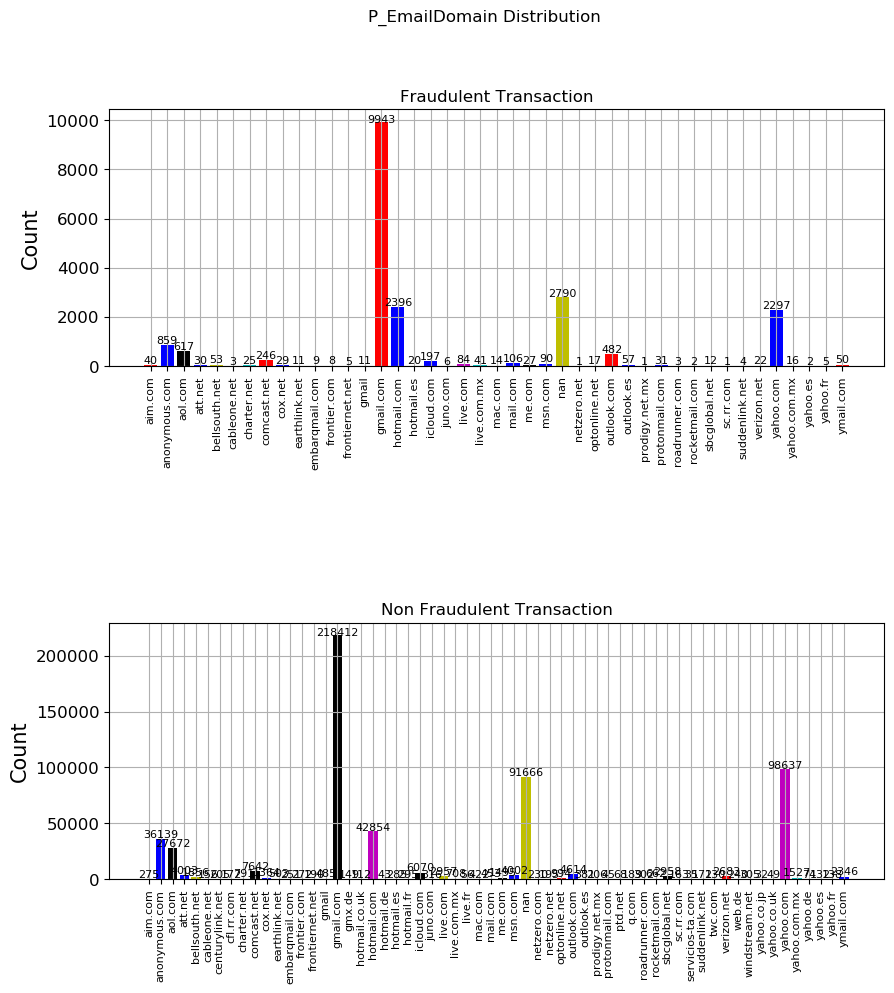

From the above plots we can infer that Both for fraudulent and non-fraudulent transactions from 'gmail.com' domain is more.


In [262]:
#P_EmailDomain
pEmail_Fraud , pEmail_cnt_Fraud = np.unique(tt_isFraud['P_emaildomain'].tolist() , return_counts=True)
pEmail_NFraud , pEmail_cnt_NFraud = np.unique(tt_isNFraud['P_emaildomain'].tolist() , return_counts=True)

fig, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
fig.suptitle('P_EmailDomain Distribution',fontsize=12)
fig.subplots_adjust(hspace=1)
ax1.set_title('Fraudulent Transaction')
ax1.set_ylabel('Count')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_ylabel('Count')
ax1.grid()
ax2.grid()
ax1.tick_params(axis='x', rotation=90 , labelsize='8')
ax2.tick_params(axis='x', rotation=90 , labelsize='8' )
rects1 = ax1.bar(pEmail_Fraud ,pEmail_cnt_Fraud , color=plot_colours)
rects2 = ax2.bar(pEmail_NFraud ,pEmail_cnt_NFraud, color=plot_colours )
def autolabel(rects , ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.99*height,
                '%d' % int(height),
                ha='center', va='bottom' , fontsize=8)

autolabel(rects1 , ax1)
autolabel(rects2,ax2)

plt.show()

print('From the above plots we can infer that Both for \
fraudulent and non-fraudulent transactions from \'gmail.com\' domain is more.')

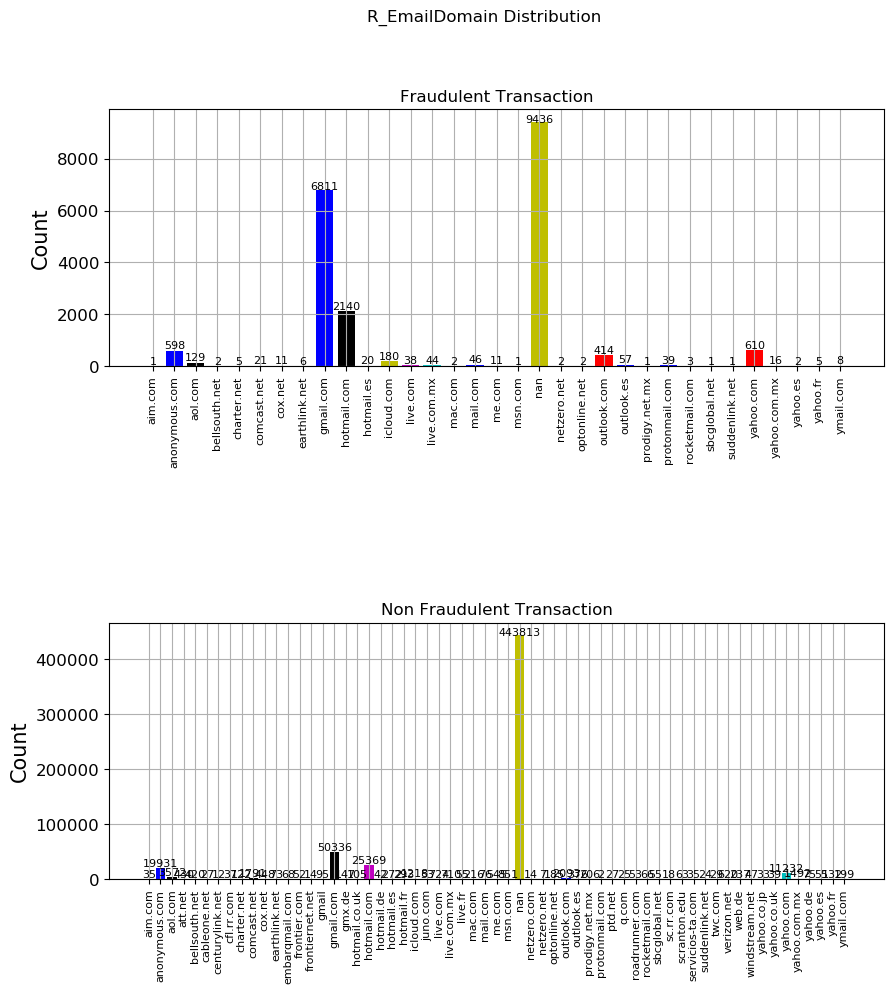

1. Nan - is the highest frequency for both frad and non-fraud 
 2. The second highest frequency for R_EmailDomian is gmail.com 


In [263]:
#R_emaildomain
rEmail_Fraud , rEmail_cnt_Fraud = np.unique(tt_isFraud['R_emaildomain'].tolist() , return_counts=True)
rEmail_NFraud , rEmail_cnt_NFraud = np.unique(tt_isNFraud['R_emaildomain'].tolist() , return_counts=True)

fig, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
fig.suptitle('R_EmailDomain Distribution',fontsize=12)
fig.subplots_adjust(hspace=1)
ax1.set_title('Fraudulent Transaction')
ax1.set_ylabel('Count')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_ylabel('Count')
ax1.grid()
ax2.grid()
ax1.tick_params(axis='x', rotation=90 , labelsize='8')
ax2.tick_params(axis='x', rotation=90 , labelsize='8' )
rects1 = ax1.bar(rEmail_Fraud ,rEmail_cnt_Fraud , color=plot_colours)
rects2 = ax2.bar(rEmail_NFraud ,rEmail_cnt_NFraud, color=plot_colours )
def autolabel(rects , ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.99*height,
                '%d' % int(height),
                ha='center', va='bottom' , fontsize=8)

autolabel(rects1 , ax1)
autolabel(rects2,ax2)

plt.show()

print('1. Nan - is the highest frequency for both frad and non-fraud \n \
2. The second highest frequency for R_EmailDomian is gmail.com ')

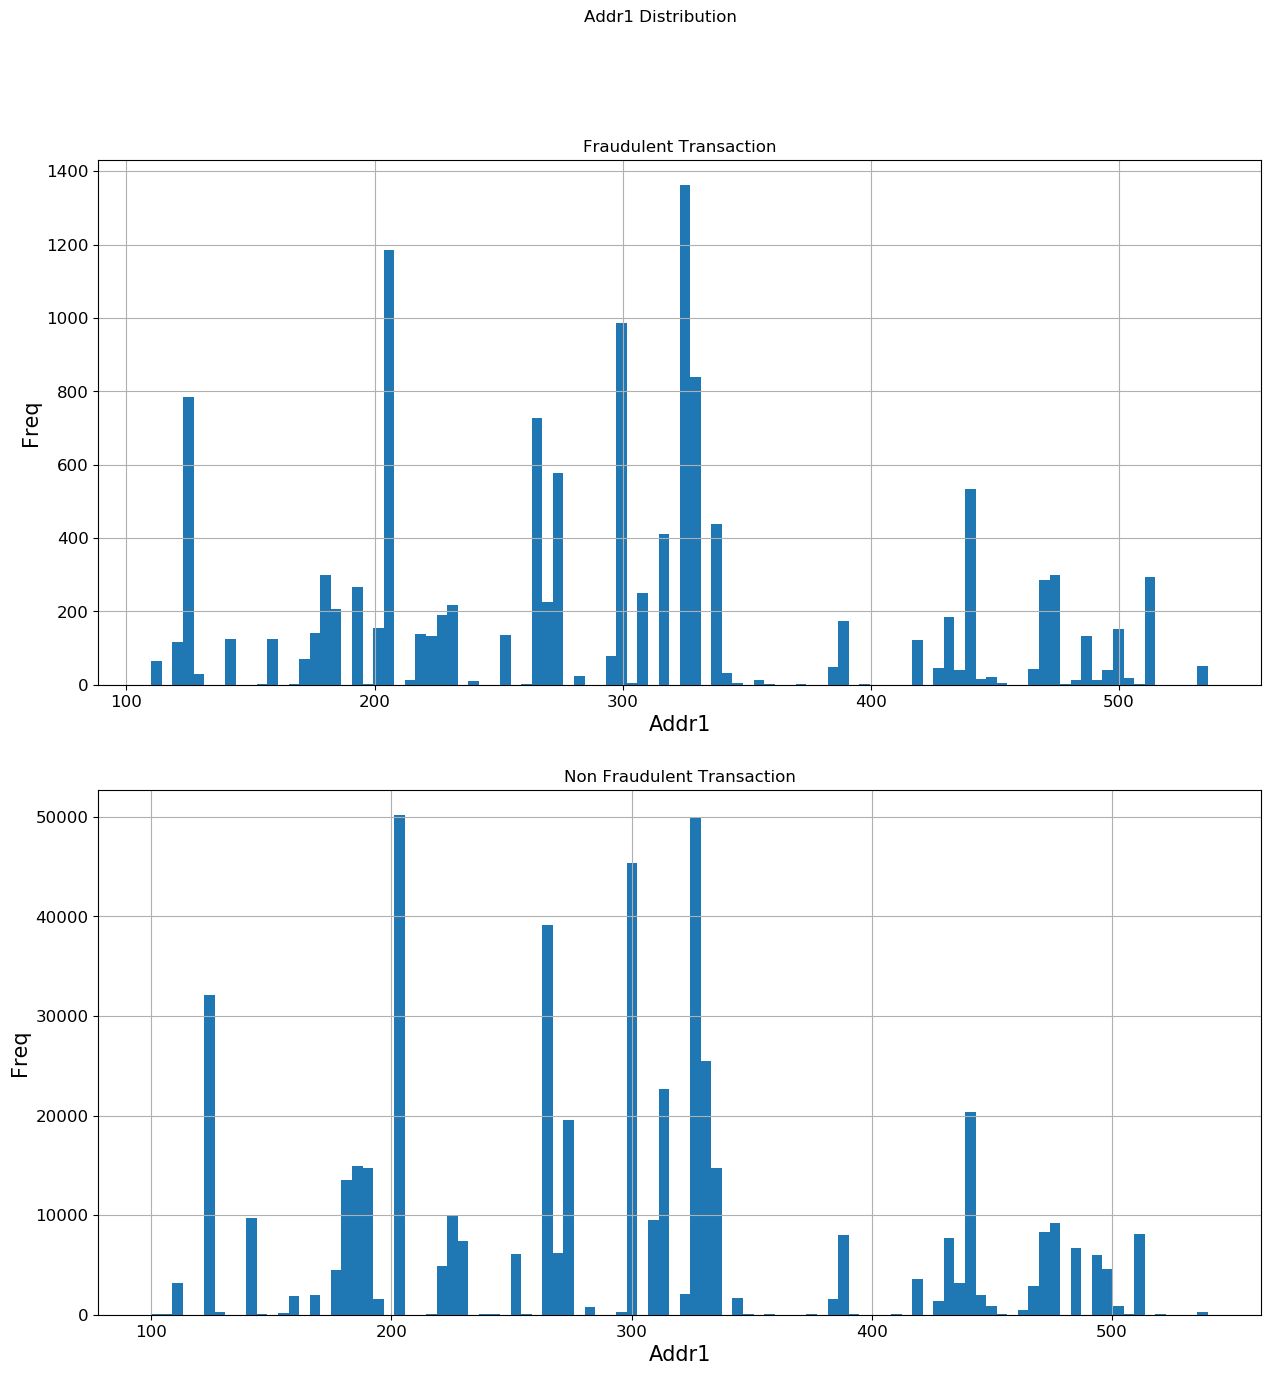

In [264]:
#Addr1
fig, (ax1, ax2) = plt.subplots(2,figsize=(15,15))
fig.suptitle('Addr1 Distribution',fontsize=12)
ax1.set_title('Fraudulent Transaction')
ax1.set_xlabel('Addr1')
ax1.set_ylabel('Freq')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_xlabel('Addr1')
ax2.set_ylabel('Freq')
_ = tt_isFraud.addr1.hist(bins=100, ax=ax1)
_ = tt_isNFraud.addr1.hist(bins = 100 ,ax=ax2)
plt.show()

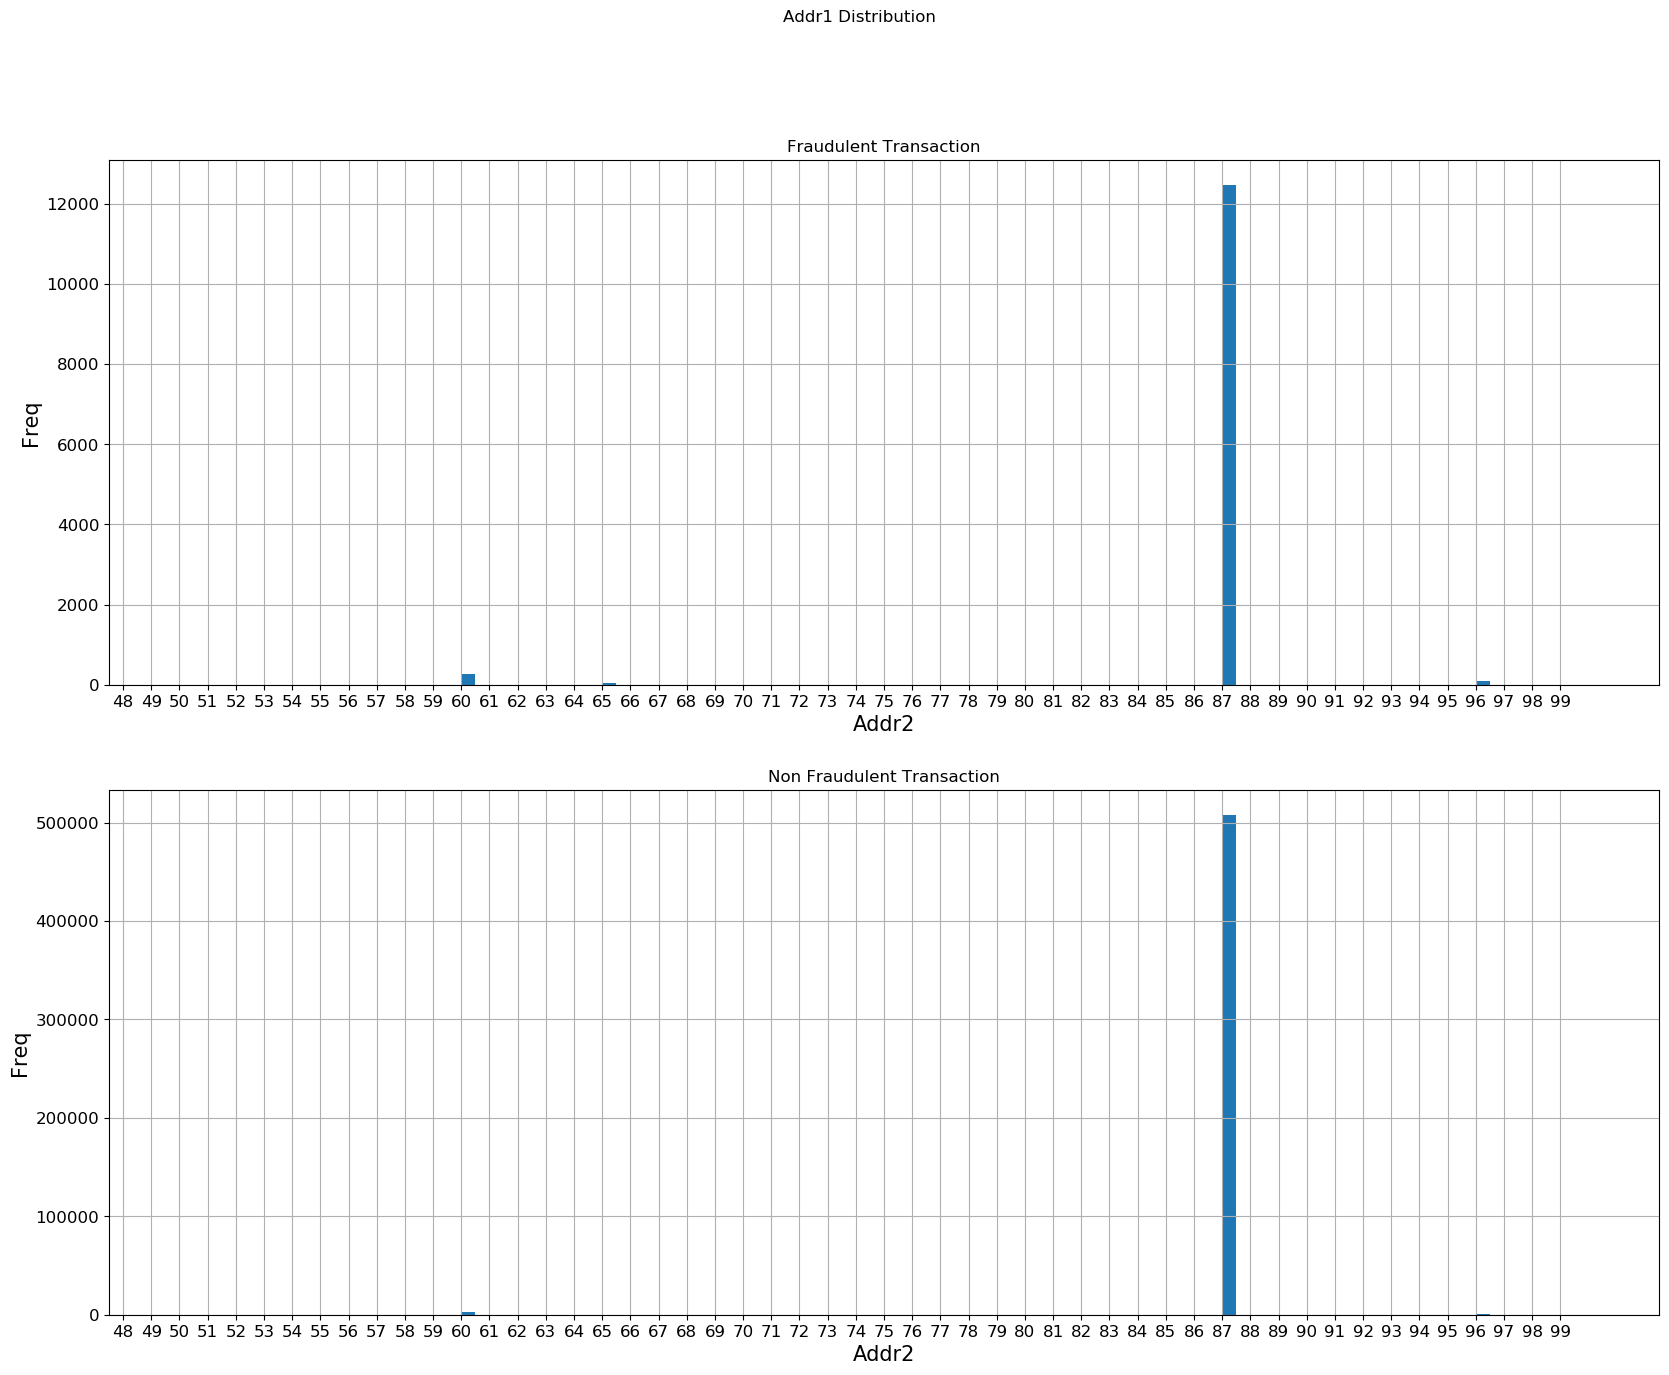

From the above plot we can see that for both fraud and non-fraud data the billing country code = '87' has the most number of transactions 


In [265]:
#Addr2
fig, (ax1, ax2) = plt.subplots(2,figsize=(20,15))
fig.suptitle('Addr1 Distribution',fontsize=12)
ax1.set_title('Fraudulent Transaction')
ax1.set_xlabel('Addr2')
ax1.set_ylabel('Freq')
ax1.set_xticks(range(0,100,1))
ax2.set_title('Non Fraudulent Transaction')
ax2.set_xlabel('Addr2')
ax2.set_ylabel('Freq')
ax2.set_xticks(range(0,100,1))
_ = tt_isFraud.addr2.hist(bins=100, ax=ax1 , range = (50,100))
_ = tt_isNFraud.addr2.hist(bins = 100 ,ax=ax2 , range = (50,100))
plt.show()

print('From the above plot we can see that for both fraud and non-fraud data the \
billing country code = \'87\' has the most number of transactions ')

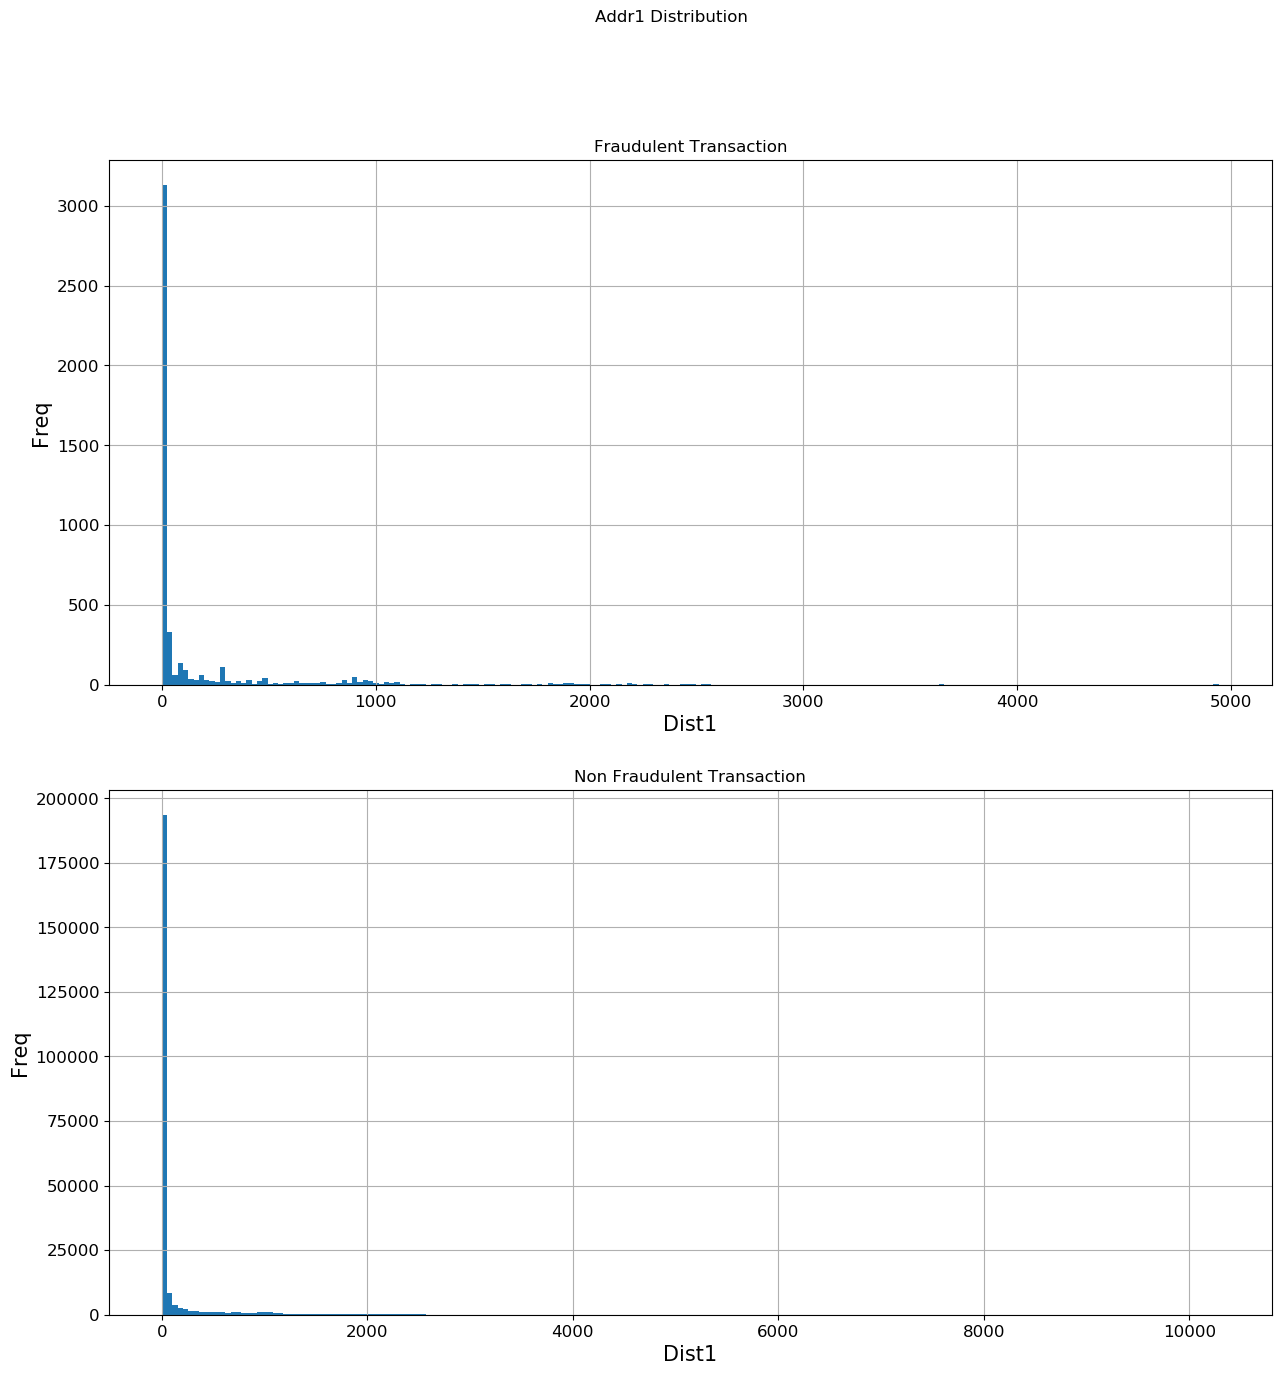

From the above plots we can infer that Both for fraudulent and non-fraudulent transactions dist1 in the range 0-200 is maximum 


In [266]:
#Dist1
fig, (ax1, ax2) = plt.subplots(2,figsize=(15,15))
fig.suptitle('Addr1 Distribution',fontsize=12)
ax1.set_title('Fraudulent Transaction')
ax1.set_xlabel('Dist1')
ax1.set_ylabel('Freq')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_xlabel('Dist1')
ax2.set_ylabel('Freq')
_ = tt_isFraud.dist1.hist(bins=200, ax=ax1)
_ = tt_isNFraud.dist1.hist(bins = 200 ,ax=ax2)
plt.show()

print('From the above plots we can infer that Both for \
fraudulent and non-fraudulent transactions dist1 in the range 0-200 is maximum ')

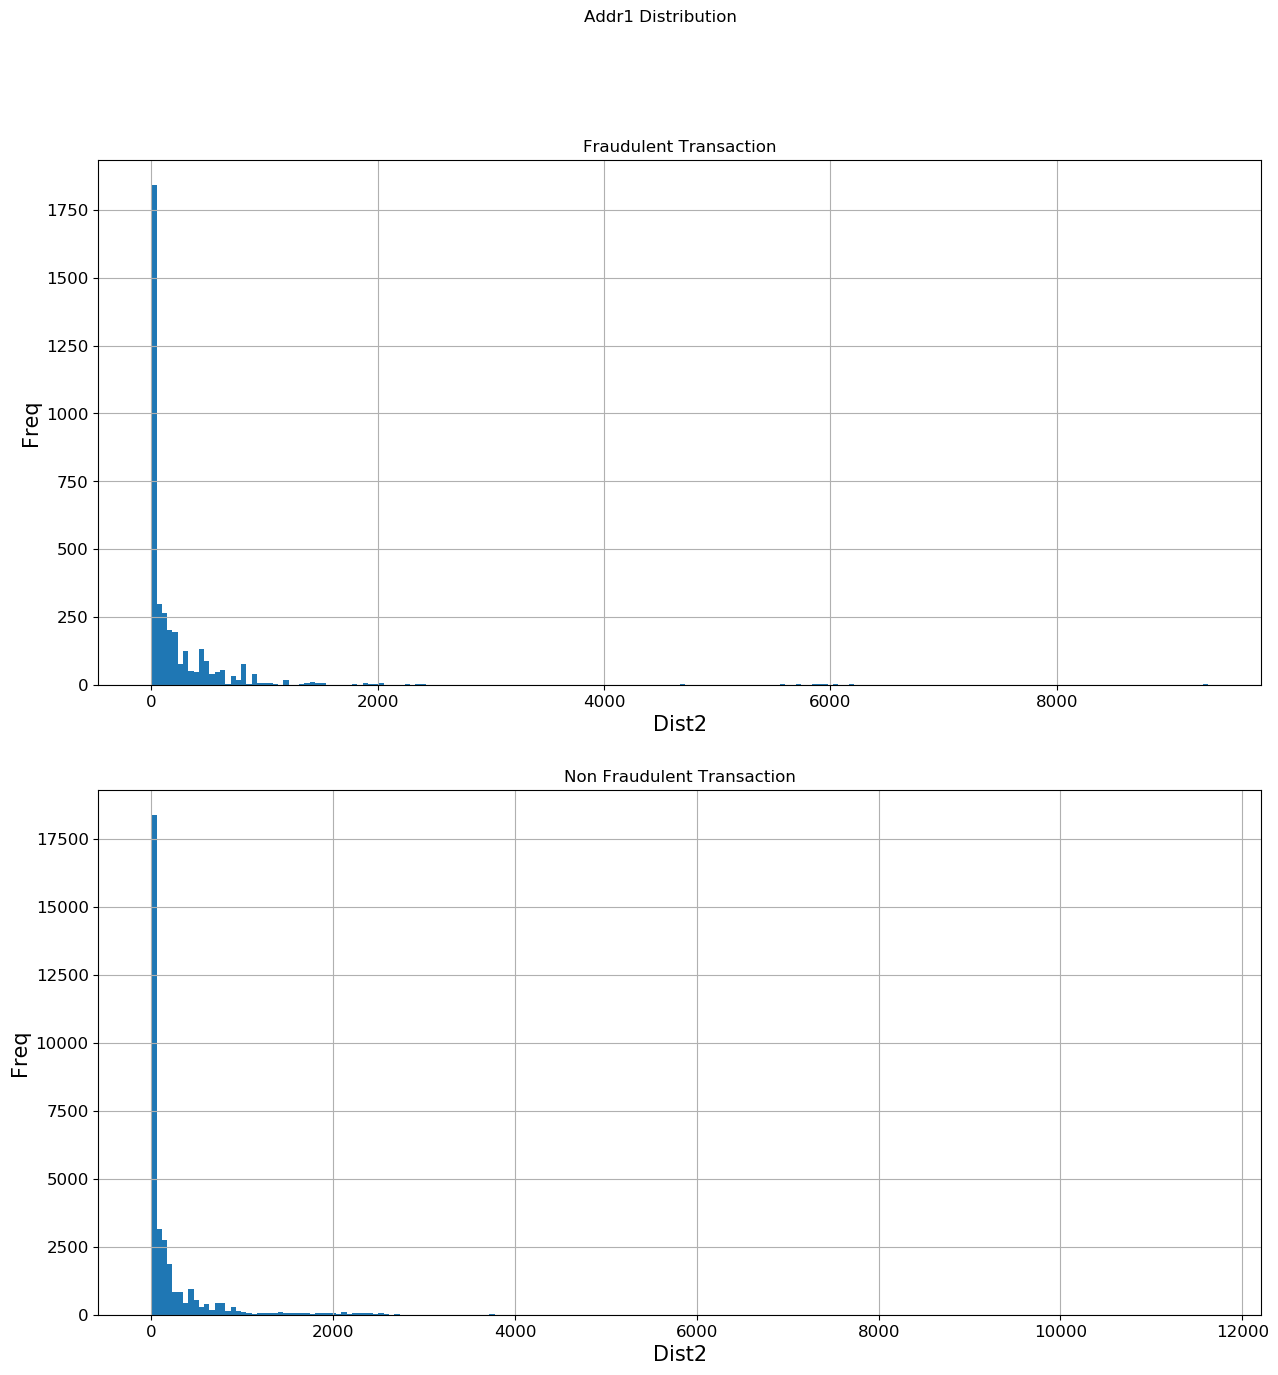

From the above plots we can infer that Both for fraudulent and non-fraudulent transactions dist2 in the range 0-200 is maximum 


In [267]:
#dist2
fig, (ax1, ax2) = plt.subplots(2,figsize=(15,15))
fig.suptitle('Addr1 Distribution',fontsize=12)
ax1.set_title('Fraudulent Transaction')
ax1.set_xlabel('Dist2')
ax1.set_ylabel('Freq')
ax2.set_title('Non Fraudulent Transaction')
ax2.set_xlabel('Dist2')
ax2.set_ylabel('Freq')
_ = tt_isFraud.dist2.hist(bins=200, ax=ax1)
_ = tt_isNFraud.dist2.hist(bins = 200 ,ax=ax2)
plt.show()

print('From the above plots we can infer that Both for \
fraudulent and non-fraudulent transactions dist2 in the range 0-200 is maximum ')

**Transaction ID:** \
Is unique for all data, no inference can be draw from this

**DeviceType** \
From the above plots we can observe that
1. More fraudlent transactions are from Mobile device type
2. More Non-Fraudlent transactions is from desktop device type

**DeviceInfo** \
From the above plots we can observe that Both fraudulent and non-fraudulent transactions are from DeviceInfo = 'Windows'

**TransactionDT** \
As seen from the above plots
A pattern can be seen from the plot where for some range of TransactionDT the number of transactions increases and then decreases which follows a wave pattern.
TransactionDT value can be divided by 3600 which give the value of TransactionDT in hours with respect to a refernce time

**TransactionAmt** \
Freq of Fraud Transaction amount is highest in 0-150
Freq of Non-Fraud Transaction amount is highest in 0-150
isFraudMaxAmt = 5191.0
isFraudMaxAmt = 0.292
isFraudMeanTAmt = 149.2447785897534
isNFraudMaxTAmt = 31937.391
isNFraudMinAmt = 0.251
isNFraudMeanTAmt = 134.51166457896034

**ProductCD** \
From the above plot we can see that
1. For fraudulent transactions product 'W' and product 'C' are more frequent products
2. For non-fraud transactions product 'W' has the maximum frequency

**Card4** \
From the above plots we can infer that Both for fraudulent and non-fraudulent transactions the card which is used more is 'VISA'

**Card6** \
From the above plots we can infer that Both for fraudulent and non-fraudulent transactions the card6 which is used more is 'Debit'

**P_EmailDomain** \
From the above plots we can infer that Both for fraudulent and non-fraudulent transactions from 'gmail.com' domain is more.

**R_emaildomain** \
1. Nan - is the highest frequency for both frad and non-fraud
2. The second highest frequency for R_EmailDomian is gmail.com

**Addr2** \
From the above plot we can see that for both fraud and non-fraud data the billing country code = '87' has the most number of transactions

**Dist1** and **Dist2** \ 
From the above plots we can infer that Both for fraudulent and non-fraudulent transactions dist1 and dist2 in the range 0-200 is maximum


## Part 2 - Transaction Frequency

In [268]:
#Count the frequency of differnet addr present in addr2 for fraudulent and non-fraudulent data
tt_isFraud_addr2_value = tt_isFraud['addr2'].value_counts()
tt_isFraud_addr2_count = tt_isFraud_addr2_value.rename_axis('addr2').reset_index(name = 'count')

tt_isNFraud_addr2_value = tt_isNFraud['addr2'].value_counts()
tt_isNFraud_addr2_count = tt_isNFraud_addr2_value.rename_axis('addr2').reset_index(name = 'count')

#Get the max count based on 'count' column
max_addr2_Fraud  = tt_isFraud_addr2_count['count'].max()
max_addr2_NFraud = tt_isNFraud_addr2_count['count'].max()

addr2_max_Fraud = tt_isFraud_addr2_count.loc[tt_isFraud_addr2_count['count'] == max_addr2_Fraud, 'addr2'].iloc[0]
addr2_max_NFraud = tt_isNFraud_addr2_count.loc[tt_isNFraud_addr2_count['count'] == max_addr2_NFraud, 'addr2'].iloc[0]
print("Max value of addr2 for Fraud is :"+str(addr2_max_Fraud))
print("Max value of addr2 for Non-Fraud is :"+str(addr2_max_NFraud))


#Filter out data based on the max addr2 field
addr2_Fraud = tt_isFraud['addr2'] == addr2_max_Fraud
tt_Fraud_ccMax = tt_isFraud[addr2_Fraud]

addr2_NFraud = tt_isNFraud['addr2'] == addr2_max_NFraud
tt_NFraud_ccMax = tt_isNFraud[addr2_NFraud]

#Print the no of values in the dataset which belongs to addr2 = max addr2
print("No of fraud records with addr2 = " + str(addr2_max_Fraud) + " : " + str(tt_Fraud_ccMax.shape))
print("No of Non-fraud records with addr2 = " + str(addr2_max_NFraud) + " : " + str(tt_NFraud_ccMax.shape))


#Divide the TransactionDT field by 3600. This will give time is hours starting from 24th hour from a refernece time.
#Sub 24 to start the time from 0th hour.
cp_tt_NFraud_ccMax = tt_NFraud_ccMax.copy()
cp_tt_NFraud_ccMax['TransactionDT'] = tt_NFraud_ccMax['TransactionDT'].apply(lambda x: int(x/3600)-24)

cp_tt_Fraud_ccMax = tt_Fraud_ccMax.copy()
cp_tt_Fraud_ccMax['TransactionDT'] = tt_Fraud_ccMax['TransactionDT'].apply(lambda x:int(x/3600)-24)

Max value of addr2 for Fraud is :87.0
Max value of addr2 for Non-Fraud is :87.0
No of fraud records with addr2 = 87.0 : (12477, 394)
No of Non-fraud records with addr2 = 87.0 : (508004, 394)


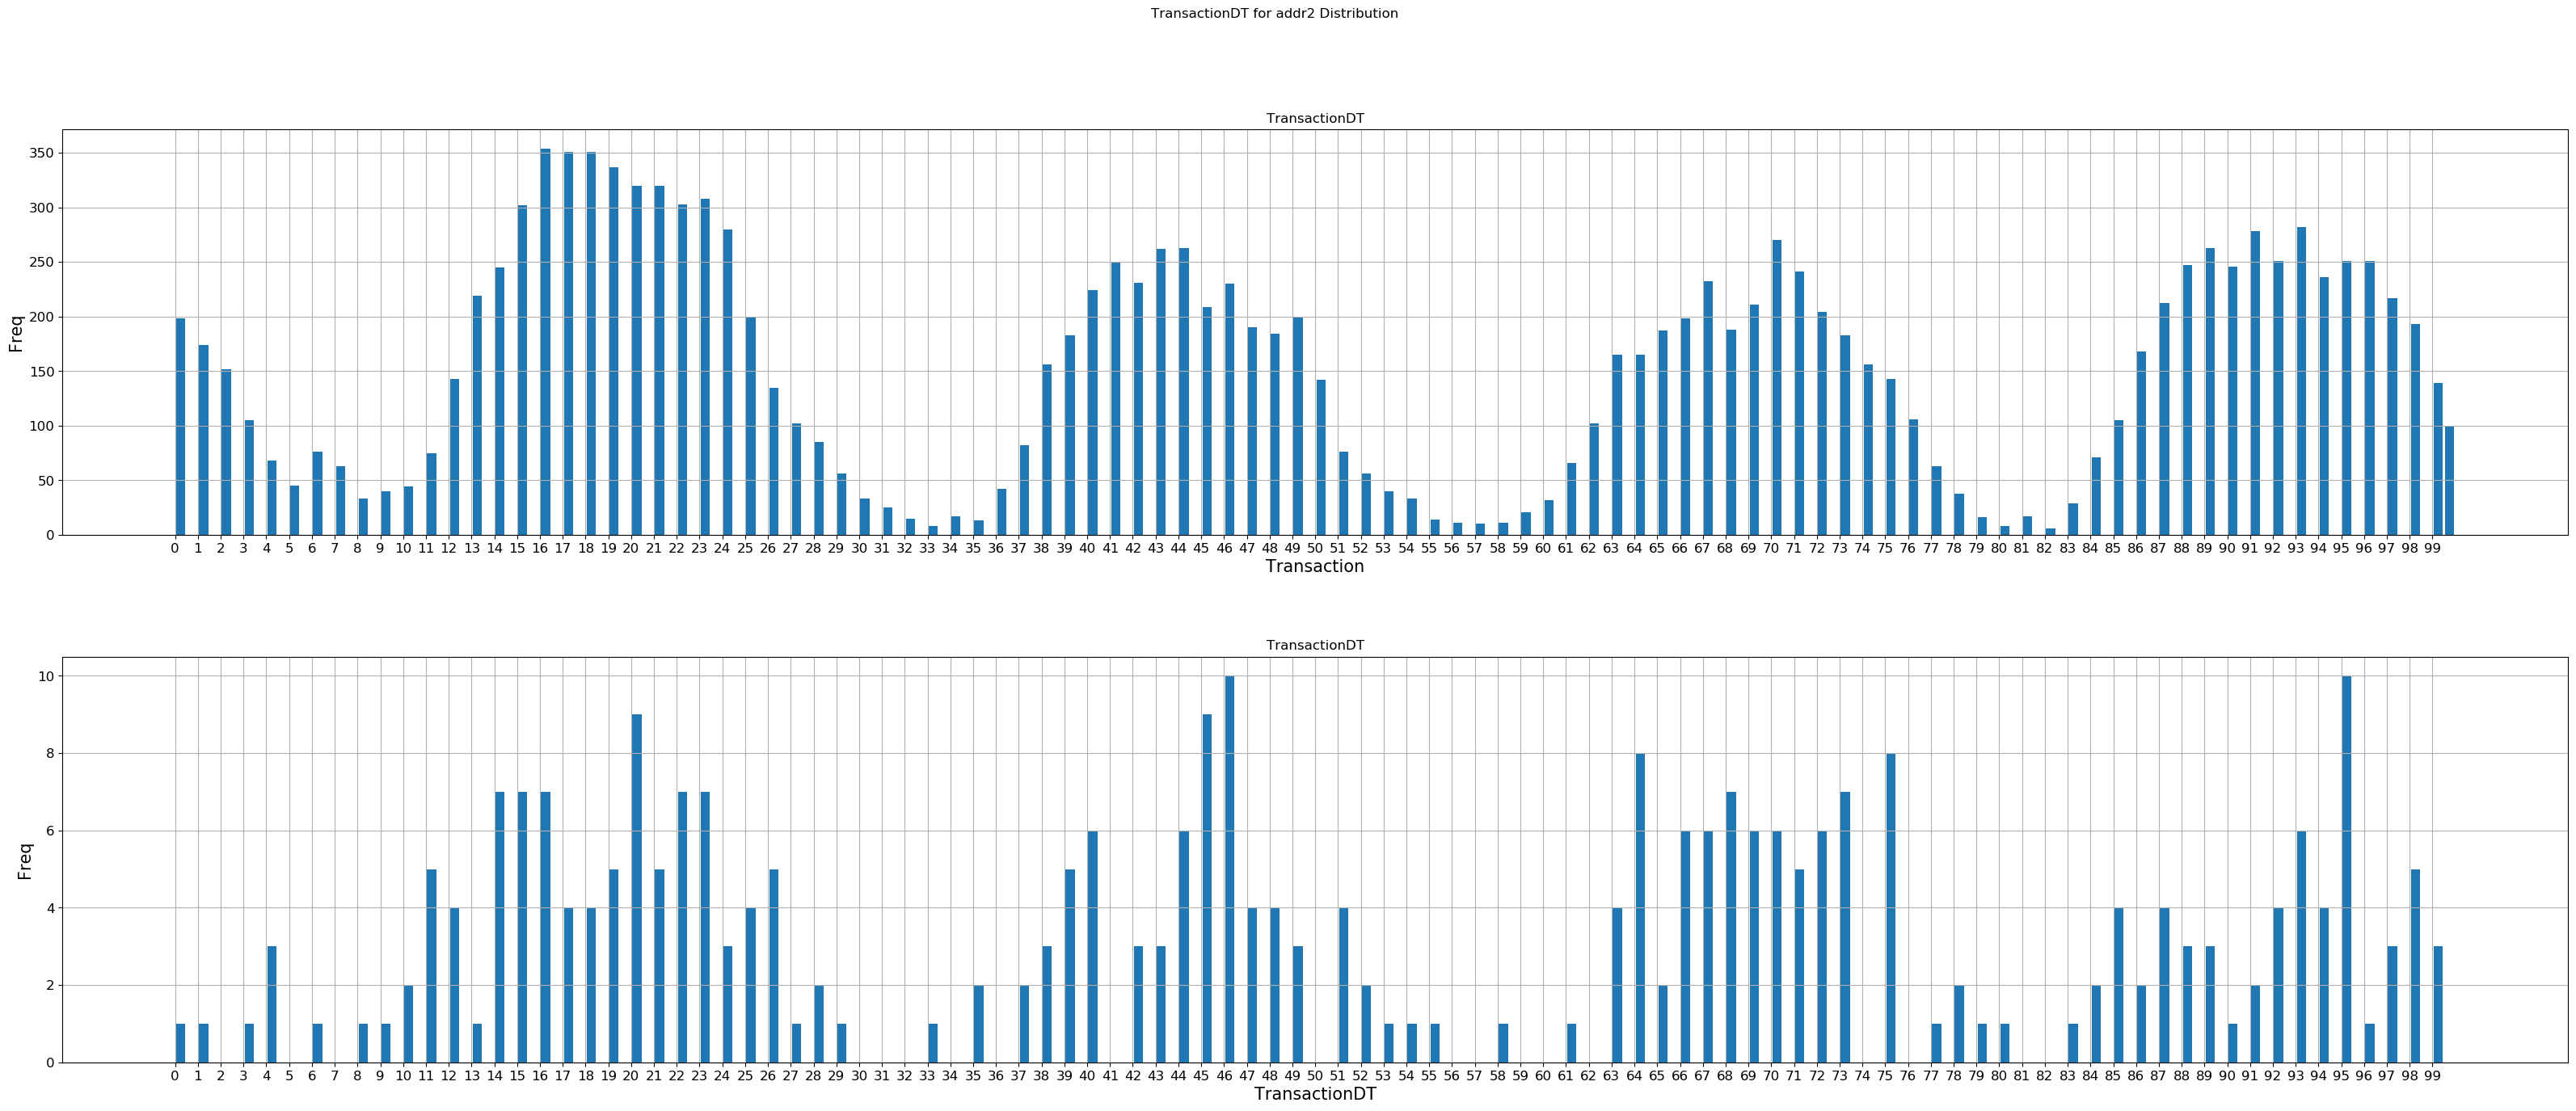

In [269]:
#Plot transactionDT which is in hours starting from 0th hour for addr2
fig, (ax1, ax2) = plt.subplots(2,figsize=(40,15))
fig.suptitle('TransactionDT for addr2 Distribution',fontsize=12)
ax1.set_title('Non Fraudulent Transaction')
ax1.set_xlabel('Transaction')
ax1.set_ylabel('Freq')
ax1.set_xticks(range(0,100,1))
ax2.set_title('Fraudulent Transaction')
ax2.set_xlabel('TransactionDT')
ax2.set_ylabel('Freq')
ax2.set_xticks(range(0,100,1))
_ = cp_tt_NFraud_ccMax.hist('TransactionDT',rwidth=0.8 , bins=200 ,range=(0,100) ,ax=ax1)
_ = cp_tt_Fraud_ccMax.hist('TransactionDT',rwidth=0.8 , bins=200 ,range=(0,100) ,ax=ax2)
plt.show()

In [270]:
#Get unique values and count of TransactionDT and calculate the delta difference between consecutive hours.

trans_count = cp_tt_NFraud_ccMax['TransactionDT'].value_counts()
transDT_cnt = trans_count.rename_axis('TransactionDT').reset_index(name = 'count')
transDT_cnt.sort_values('TransactionDT' , inplace = True)
transDT_diff_arr={}
for i in range(0,24):
    transDT_diff_arr[i] = (transDT_cnt.iloc[i+1]['count'] - transDT_cnt.iloc[i]['count'])
max_diff_TransactionDT = sorted(transDT_diff_arr.items(), key=operator.itemgetter(1))[-1][1]

print("Maximum difference between the 2 transaction DT's happen at reference time = 12.\n\
From 11'th hr to 12'th hr there is a maximum rise is TransactionDT's frequency which is = "+str(max_diff_TransactionDT))

Maximum difference between the 2 transaction DT's happen at reference time = 12.
From 11'th hr to 12'th hr there is a maximum rise is TransactionDT's frequency which is = 76


Maximum difference between the 2 transaction DT's happen at reference time = 12. \
From 11'th hr to 12'th hr there is a maximum rise is TransactionDT's frequency which is = 76 \

So waking hours associated with the country with addr2 relative to the reference time starts at **12th hour**.

Relative to reference time the time in hours from **12th hour to 24th hour** can be considered as **waking time**

## Part 3 - Product Code

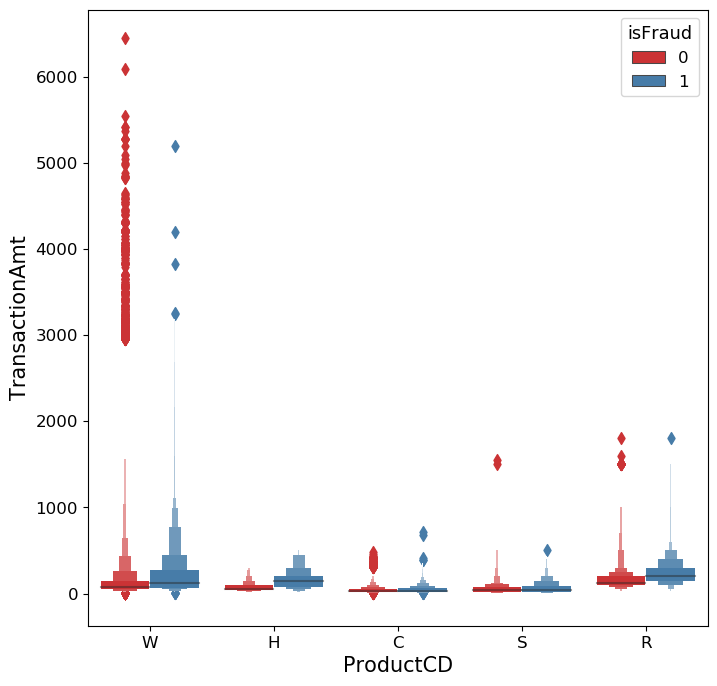

Mean Transaction Amt of Product : W 151.57823156250288
Median Transaction Amt of Product : W 77.95
Mode Transaction Amt of Product : W 0    59.0
dtype: float64

Mean Transaction Amt of Product : R 165.32751633446364
Median Transaction Amt of Product : R 125.0
Mode Transaction Amt of Product : R 0    100.0
dtype: float64

Mean Transaction Amt of Product : C 42.077462990199244
Median Transaction Amt of Product : C 30.781999999999996
Mode Transaction Amt of Product : C 0    32.356
dtype: float64

Mean Transaction Amt of Product : H 68.99001589825119
Median Transaction Amt of Product : H 50.0
Mode Transaction Amt of Product : H 0    50.0
dtype: float64

Mean Transaction Amt of Product : S 60.08020471577409
Median Transaction Amt of Product : S 35.0
Mode Transaction Amt of Product : S 0    50.0
dtype: float64

Percentage of ProductCD W equal to mode is : 69.48759025794618
Percentage of ProductCD R equal to mode is : 32.117553000854635
Percentage of ProductCD C equal to mode is : 0.525524284

In [271]:
#Boxenplot provides more information about the shape of the distribution, particularly in the tails
#https://seaborn.pydata.org/generated/seaborn.boxenplot.html
plt.figure(figsize=(8, 8))
_ = sns.boxenplot(x="ProductCD", y="TransactionAmt", data=train_trans[train_trans.TransactionAmt <= 8000],hue="isFraud",palette="Set1")
plt.show()

#Median of all product code are
productCD = ['W','R','C','H','S']
count = [43071 , 36273 , 60511 , 31450 , 10942]
for i in productCD:
    print("Mean Transaction Amt of Product : "+ i + " " + str(tt_isNFraud[tt_isNFraud['ProductCD'] == i]['TransactionAmt'].mean()))
    print("Median Transaction Amt of Product : "+ i + " " + str(tt_isNFraud[tt_isNFraud['ProductCD'] == i]['TransactionAmt'].median()))
    print("Mode Transaction Amt of Product : "+ i + " " + str(tt_isNFraud[tt_isNFraud['ProductCD'] == i]['TransactionAmt'].mode()))
    print()
mode = [59 , 100 , 32.356 , 50 , 50]
for i , j , z in zip(productCD , mode , count):
    a = tt_isNFraud[tt_isNFraud['ProductCD'] == i]
    b = a[a['TransactionAmt'] == j]
    print("Percentage of ProductCD " + i + " equal to mode is : " + str((b.shape[0]/z)*100))

**Most Expensive Products** \
As seen from the above graph product W has a lot of outliers. \
Around 70% of data of Product H is around 59 and its median is 77.95 \
Around 32% of data of product R is around 100 and its median is 125 \

From this we can conclude that **Product R** is the **most expensive product** followed by **Product H**

**Least Expensive Products** \
**Product C** is the least expensive product followed by **Product S**

## Part 4 - Correlation Coefficient

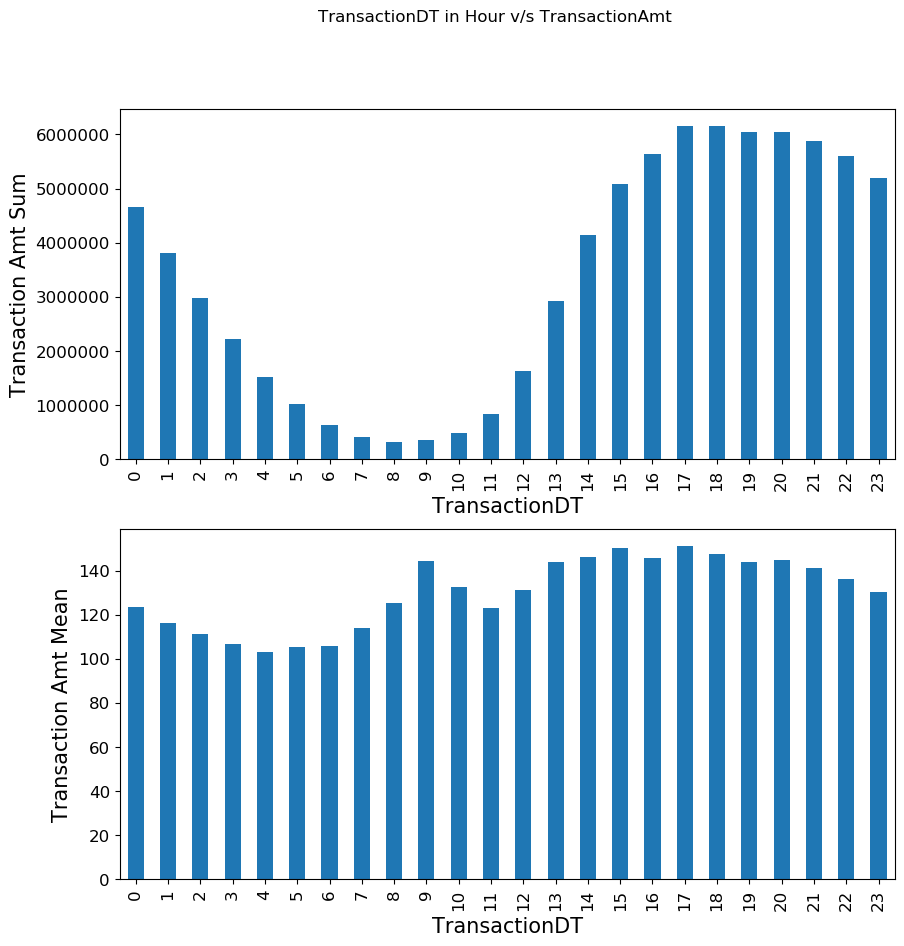

Correlation between Transaction Amount Sum vs Time in Hrs when transaction has occurred is : 0.6421174943084446
Correlation between Transaction Amount Mean vs Time in Hrs when transaction has occurred is : 0.7506793476618114


In [272]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
fig.suptitle('TransactionDT in Hour v/s TransactionAmt',fontsize=12)
ax1.set_xlabel('TransactionDT in Hours')
ax1.set_ylabel('Transaction Amt Sum')
ax2.set_xlabel('TransactionDT in Hours')
ax2.set_ylabel('Transaction Amt Mean')

trans_DT_Amt = train_trans.copy()
trans_DT_Amt['TransactionDT'] = trans_DT_Amt['TransactionDT'].apply(lambda x: int(x/3600) % 24)
trans_amt_sum = trans_DT_Amt.groupby('TransactionDT',as_index = False).agg({"TransactionAmt" : "sum"})
trans_amt_sum.plot(x = 'TransactionDT', y = 'TransactionAmt',figsize = (10,10) , kind='bar' , ax=ax1 , legend=False)
corr_hr_amt = trans_amt_sum['TransactionDT'].corr(trans_amt_sum['TransactionAmt'])

trans_DT_Amt_mean = trans_DT_Amt.groupby('TransactionDT',as_index = False).agg({"TransactionAmt" : "mean"})
trans_DT_Amt_mean.plot(x = 'TransactionDT', y = 'TransactionAmt', figsize = (10,10) , kind='bar' , ax=ax2 , legend=False)
corr_hr_AvgAmt = trans_DT_Amt_mean['TransactionDT'].corr(trans_DT_Amt_mean['TransactionAmt'])
plt.show()

print("Correlation between Transaction Amount Sum vs Time in Hrs when transaction has occurred is : " + str(corr_hr_amt))
print("Correlation between Transaction Amount Mean vs Time in Hrs when transaction has occurred is : " + str(corr_hr_AvgAmt))

**Correlation between Time of day in hours and the Purchase Amount Sum = 0.64** \
**Correlation between Time of day in hours and the Purchase Amount Mean = 0.75**

## Part 5 - Interesting Plot

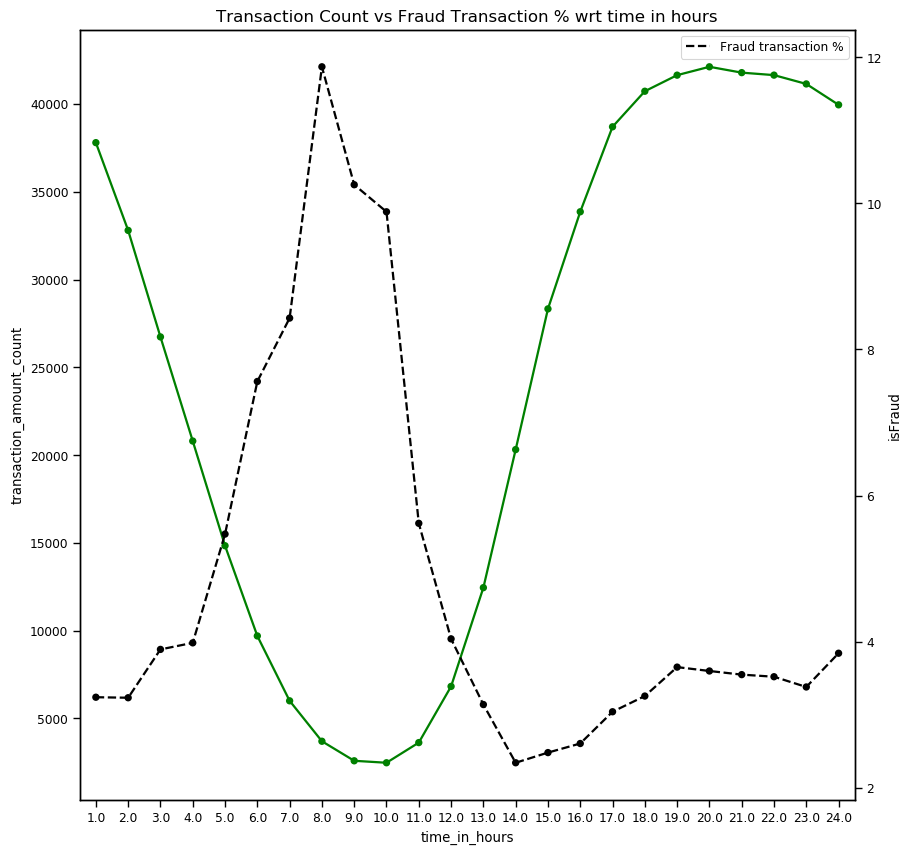

In [273]:
trans_Frad_Per = train_trans.copy()
trans_Frad_Per['TransactionDT'] = trans_Frad_Per['TransactionDT'].apply(lambda x: int(x/3600) % 24)

isFraudPer = []
transAmt_cnts = []
hrs = []

for hr in range(0, 24 , 1):
    train_hr = trans_Frad_Per[trans_Frad_Per['TransactionDT'] == hr]
    hrs.append(hr+1)
    transAmt_cnts.append(train_hr['TransactionAmt'].count())
    isFraud = (train_hr[train_hr['isFraud'] == 1])['TransactionAmt'].count()
    isNFraud = (train_hr[train_hr['isFraud'] == 0])['TransactionAmt'].count()
    isFraudPer.append((isFraud/isNFraud) * 100)

data = [isFraudPer,transAmt_cnts, hrs]
columns = ['isFraud' , 'transaction_amount_count' ,'time_in_hours']
df = pd.DataFrame(data, columns) 
df = df.T
df.head(10)
plt.figure(figsize=(10,10))

#https://stackoverflow.com/questions/36416805/seaborn-how-to-change-linewidth-and-markersize-separately-in-factorplot
rc = {'lines.linewidth': 0.9, 'lines.markersize': 1}                  
sns.set_context("paper", rc = rc)  
ptPlot = sns.pointplot(y='transaction_amount_count', x="time_in_hours", data=df, color='green')
plt.title("Transaction Count vs Fraud Transaction % wrt time in hours", fontsize=12);
_ = ptPlot.twinx()
ax1 = sns.pointplot(y="isFraud", x="time_in_hours", data=df, color="black" , linestyles=["--"])
ax1.legend(["Fraud transaction %"])
plt.show()


We can see that the % of fradulent transactions wrt total transactions during the 5th hour to 11th hour is very high. \
From the 2nd question we can see that this time is the sleeping time of the country.

## Part 6 - Prediction Model

In [274]:
#Select only the important columns from the merged data set.
merge_train1=mergeL_train[['TransactionID','TransactionDT','TransactionAmt','ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2','dist1','dist2','P_emaildomain','R_emaildomain','id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11','id_12','id_13','id_14','id_15','id_16','id_17','id_18','id_19','id_20','id_21','id_22','id_23','id_24','id_25','id_26','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_34','id_35','id_36','id_37','id_38','DeviceType','DeviceInfo']]
merge_test1=mergeL_test[['TransactionID','TransactionDT','TransactionAmt','ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2','dist1','dist2','P_emaildomain','R_emaildomain','id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11','id_12','id_13','id_14','id_15','id_16','id_17','id_18','id_19','id_20','id_21','id_22','id_23','id_24','id_25','id_26','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_34','id_35','id_36','id_37','id_38','DeviceType','DeviceInfo']]

#Fill NA values with 0
merge_train1.fillna(0.0,inplace=True)
merge_test1.fillna(0.0,inplace=True)

#Use label encoding on the dataset
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = preprocessing.LabelEncoder()
merge_train2 = merge_train1.copy()
merge_test2 = merge_test1.copy()

merge_train2['TransactionHr'] = merge_train2['TransactionDT'].apply(lambda x: int(x/3600)-24)
merge_train2['TransactionDay'] = merge_train2['TransactionHr'].apply(lambda x: x%24)
merge_test2['TransactionHr'] = merge_test2['TransactionDT'].apply(lambda x: int(x/3600)-24)
merge_test2['TransactionDay'] = merge_test2['TransactionHr'].apply(lambda x: x%24)

list_var = ['ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2','dist1','dist2','P_emaildomain','R_emaildomain','id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11','id_12','id_13','id_14','id_15','id_16','id_17','id_18','id_19','id_20','id_21','id_22','id_23','id_24','id_25','id_26','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_34','id_35','id_36','id_37','id_38','DeviceType','DeviceInfo']

for i in list_var:
    val = list(merge_train2[i].values.astype(str)) + list(merge_test2[i].values.astype(str))
    le.fit(val)
    merge_train2[i] = le.transform(merge_train2[i].astype(str))
    merge_test2[i] = le.transform(merge_test2[i].astype(str))


#Split the data set into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(merge_train2 , mergeL_train['isFraud'] , test_size=0.2)

C:\Users\ajayg\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [275]:
#This is RandomForestRegressor
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# reg_obj = RandomForestRegressor(n_estimators=150)
# reg_obj.fit(X_train,y_train)
# predict_test = reg_obj.predict(X_test)
# print(accuracy_score(y_test , predict_test.round()))


# cat_model_out = reg_obj.predict(merge_test2)
# output_df = pd.DataFrame({'TransactionID':merge_test2['TransactionID'] , 'isFraud' : cat_model_out[:]})
# output_df.to_csv(file_path+'submission.csv' , index=False)

# Accurancy score - 0.9825498696108647

In [276]:
#Do pip install of catboost to get Cat boostregressor
#https://www.analyticsvidhya.com/blog/2017/08/catboost-automated-categorical-data/
#https://catboost.ai/docs/concepts/python-usages-examples.html
reg_obj = CatBoostRegressor(
    iterations=7000,
    eval_metric="AUC",
    task_type="GPU",
    devices='0:1',
    verbose=False
)

reg_obj.fit(X_train,y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

No handles with labels found to put in legend.


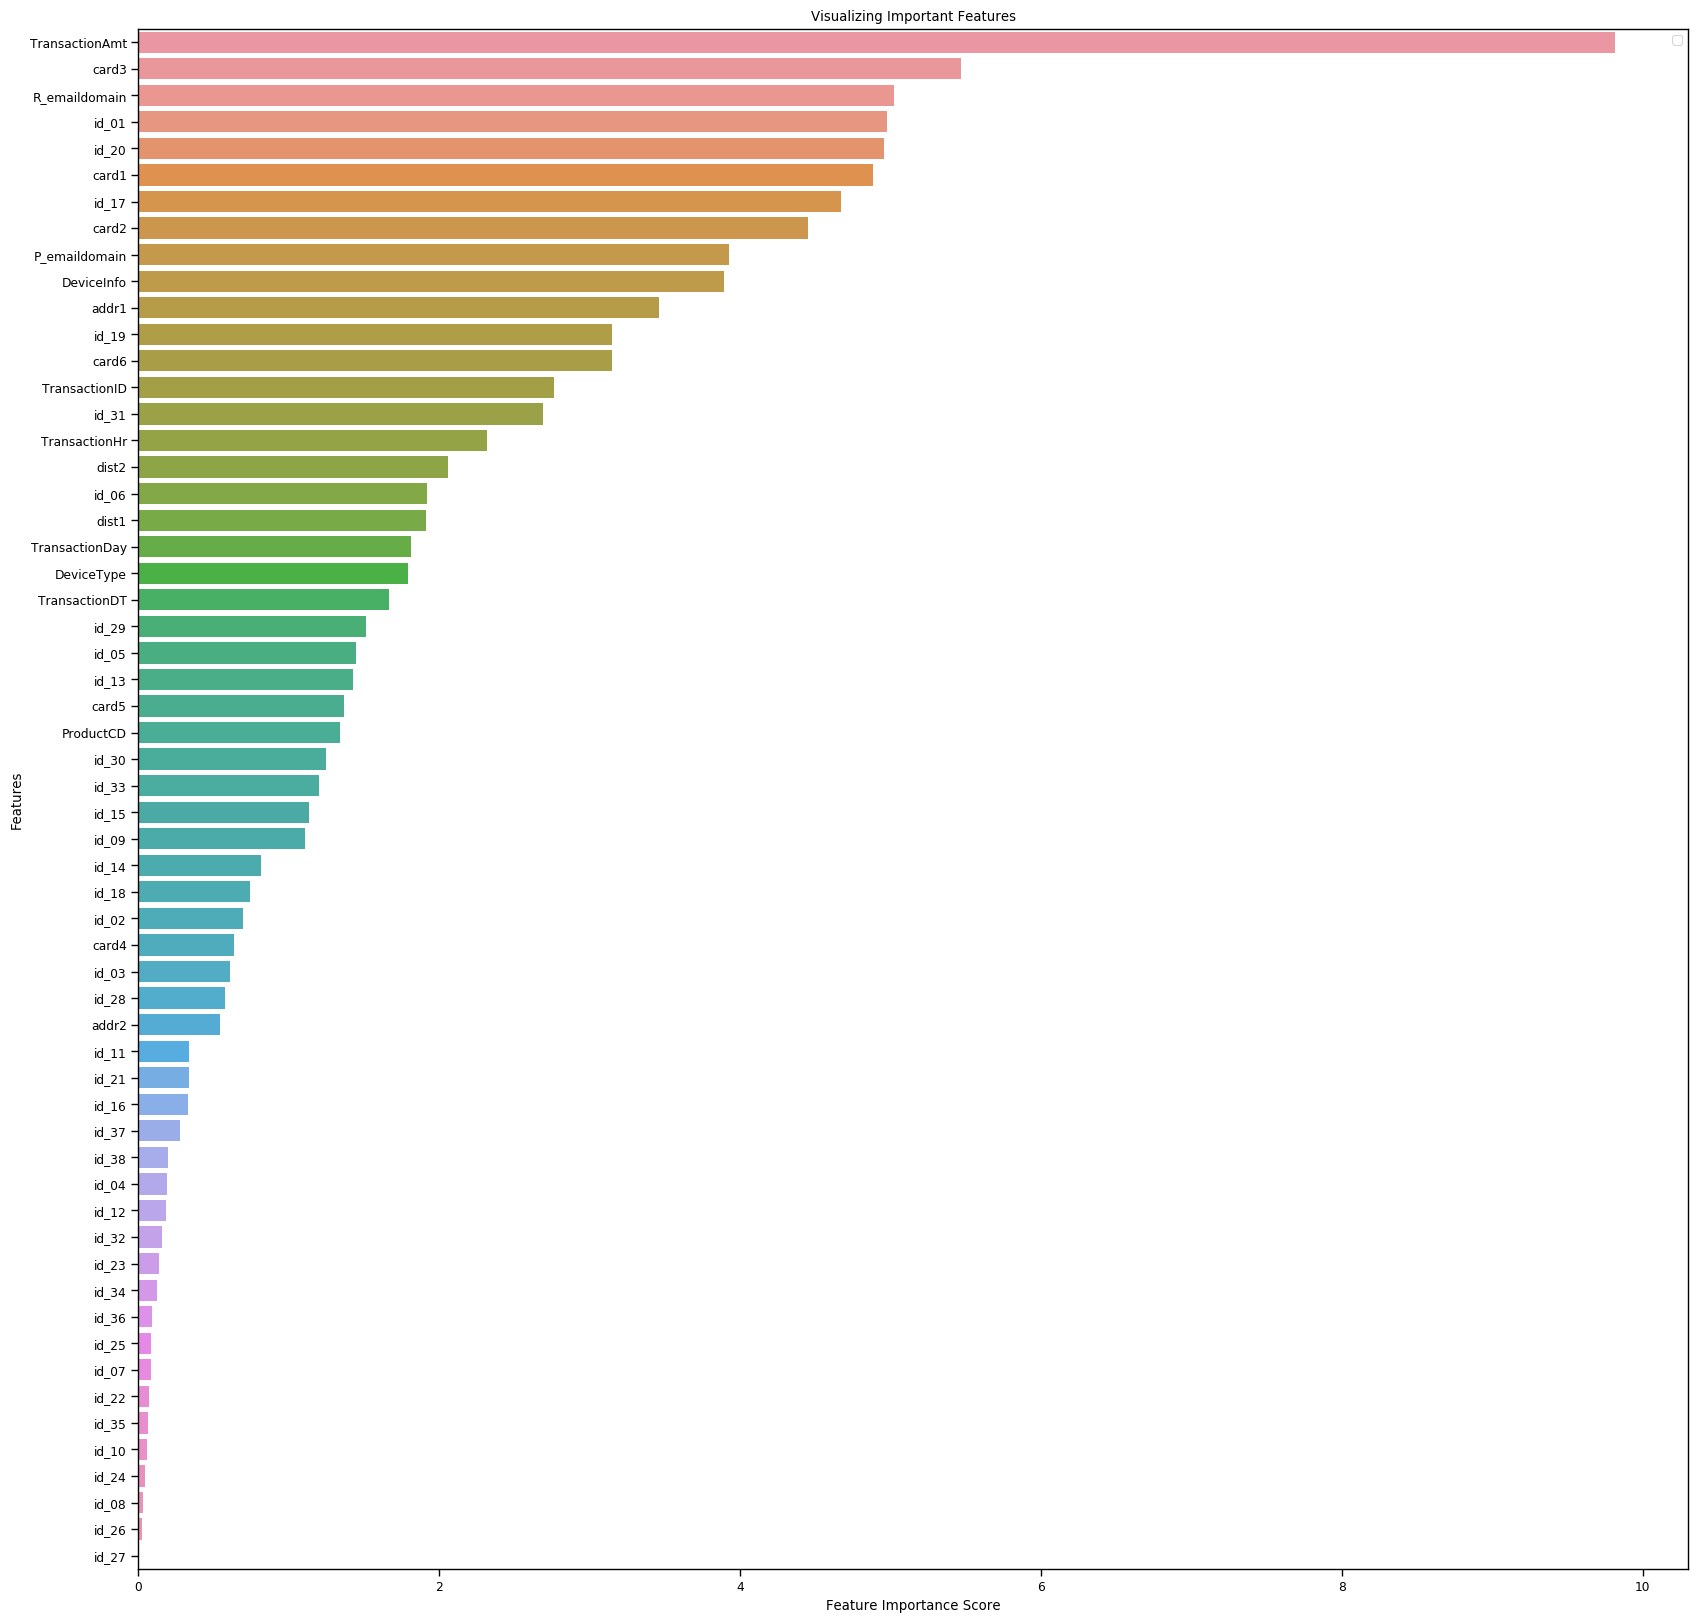

In [277]:
#Important features of catboost regressor can be ploted as shown.
feature_imp = pd.Series(reg_obj.feature_importances_,index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(20, 20))

sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend();
plt.show();

In [278]:
#Predict the final value based of the regression object model and create a submission.csv output file
x_test_predict = reg_obj.predict(X_test)
print("Accuracy score : " + str(accuracy_score(y_test , x_test_predict.round())))
cat_model_out = reg_obj.predict(merge_test2)
output_df = pd.DataFrame({'TransactionID':merge_test2['TransactionID'] , 'isFraud' : cat_model_out[:]})
output_df.to_csv(file_path+'submission.csv' , index=False)

#Accuracy score - 0.97

Accuracy score : 0.9716361296440545


From the merged data set, only the required columns were seperated out.
1. I have added extra columns called TransactionHr and TransactionDay which represents time in hours and time in a day. (0-23).
2. All the NA values were filled with zero.
3. I have used label encoding which encode labels with value between 0 and n_classes-1.
4. The merged data was then split into 2 parts. Training set(80%) and the testing set(20%)
5. Using the training set 2 models were trained
    a. RandomForestRegressor - RandomForestRegressor gave a accuracy score of 0.98 and a kaggle score of 0.8379.
       The issue with RandomForestRegressor is it takes a lot of time for training the model.
       I tried different values for n_estimators and n_estimators = 150 gave a good result.
       As RandomForestRegressor takes lot of time to model i used a model which runs on GPU
       
    b. CatBoostRegressor - CatBoostRegressor gave a accuracy score of  0.97 and a kaggle score of 0.8542.
       As CatBoostRegressor library was not available by default i had to install this using pip
       CatBoostRegressor will utilize the GPU for computation and it was extremely faster when compared to   RandomForestRegressor.

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/ajaygk

Highest Rank: 5151

Score: 0.8542

Number of entries: 7

INCLUDE IMAGE OF YOUR KAGGLE RANKING
<img src="kaggle_rank.png">